IMPORTS

In [1]:
# CORE PYTHON & DATA MANIPULATION LIBRARIES
import numpy as np                # Numerical computations, arrays, math operations
import pandas as pd               # Data handling, DataFrames, time-series structures
import os                         # OS-level utilities (path handling, directory checks, file management)
# VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt   # Main plotting library
import seaborn as sns             # Statistical and enhanced visualization tools
# STEP 3) DECOMPOSING
from statsmodels.tsa.seasonal import seasonal_decompose         # Decompose time-series into trend, seasonal, and residual components
from statsmodels.tsa.stattools import acf                       # Compute autocorrelation values
# STEP 4) STATIONARITY ANALYSIS
from statsmodels.tsa.stattools import adfuller                  # Dickey-Fuller test for stationarity evaluation
# STEP 5) RESIDUALS DIAGNOSTICS
from statsmodels.stats.diagnostic import acorr_ljungbox         # Ljung-Box test for checking autocorrelation in residuals
# STEP 6) ACF/PACF DIAGNOSTICS + ORDER GRIDS
from statsmodels.tsa.stattools import pacf                      # Compute partial autocorrelation values
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # Plot ACF & PACF with confidence bands

HELPER FUNCTIONS

In [16]:
# ===============================
# Log printer
# ===============================
def log(
    message: str,
    icon: str = "INFO",
    level: int = 1,
    bold: bool = False
):
    # Icon dictionary (semantic → emoji)
    icons = {
        "INFO": "ℹ️",
        "FOUND": "🔍",
        "SUCCESS": "✅",
        "ERROR": "❌",
        "WARNING": "⚠️",
        "SUGGESTION": "💡"
    }

    # If icon matches a key → use mapped emoji
    # Else → assume user passed a custom emoji/string
    final_icon = icons.get(icon.upper(), icon)
    # Bold wrapper (ANSI)
    if bold:
        message = f"\033[1m{message}\033[0m"
    # Prefix by level
    if level == 1:
        prefix = "•"
    elif level == 2:
        prefix = "   -"
    elif level == 3:
        prefix = "      ·"
    else:
        prefix = "-"
    # Print
    print(f"{prefix} {final_icon} {message}")

# ===============================
# Get revision number - Returns the next free integer revision based on existing files
# ===============================
def get_revision_number(base_path, base_name):
    rev = 0
    while True:
        full_path = os.path.join(base_path, base_name + "_" + str(rev) + ".csv")
        if not os.path.exists(full_path):
            return rev
        rev += 1

# ===============================
# Determines granularity given seconds
# ===============================
def determine_granularity(seconds: float) -> str:
    # Use tolerance windows (robust)
    if 3500 <= seconds <= 3700:
        return "1-hour"
    if 3.5*3600 <= seconds <= 4.5*3600:
        return "4-hour"
    if 23*3600 <= seconds <= 25*3600:
        return "1-day"
    return "other"

# ===============================
# Map granularity to pandas frequency alias
# ===============================
def get_pandas_freq_from_granularity(granularity: str) -> str | None:
    if granularity=="1-hour":
        return "h"
    if granularity=="4-hour":
        return "4h"
    if granularity=="1-day":
        return "D"
    return None

# ===============================
# Pick a safe max lag for ACF/PACF based on granularity + seasonal period
# ===============================
def get_safe_lag_for_acf_pacf(granularity: str, period_m: int, n: int, max_cap: int = 300) -> int:
    base_candidates=lag_candidates_from_granularity(granularity)  # base lags from granularity
    nice=[l for l in base_candidates if l>=2]  # keep only meaningful lags
    if period_m is not None and period_m>1:  # add seasonal period multiples if valid
        nice=nice+[period_m,2*period_m,3*period_m]  # enrich candidates with seasonality
    nice=sorted(list(set(nice)))  # deduplicate and sort candidates
    target=max(nice) if nice else 50  # choose highest candidate or default
    safe=min(target,max_cap,n-2)  # cap by user max and sample size
    return max(10,safe)  # enforce minimum lag floor

# ===============================
# Candidate seasonal periods by granularity (time steps)
# ===============================
def period_candidates_from_granularity(granularity: str) -> list[int]:
    if granularity == "1-hour":
        return [24, 168]
    if granularity == "4-hour":
        return [6, 42]
    if granularity == "1-day":
        return [7, 14]
    return []

# ===============================
# Returns an integer period (m) to use in decomposition / SARIMA.
#- If manual_period is provided -> use it.
# - Else -> try ACF among plausible candidates.
# - Else -> fallback to the first plausible candidate.
# If there are no candidates, raises ValueError.
# ===============================
def decide_seasonal_period(
    timeseries: pd.Series,
    granularity: str,
    manual_period: int | None = None,
    acf_threshold: float = 0.20
):
    candidates = period_candidates_from_granularity(granularity)
    if not candidates:
        raise ValueError(f"No valid period candidates for granularity='{granularity}'")
    # 1) Manual override
    log(f"1st) Trying to infer period from manual input:", level=2)
    if manual_period is not None:
        return manual_period, "MANUAL PERIOD"
    else:
        log(f"No manual input was indicated for seasonal period", icon="WARNING", level=3)
    # 2) ACF among candidates
    #m_acf = infer_period_from_acf_candidates(timeseries, candidates, threshold=acf_threshold)
    m_acf=infer_period_from_acf_candidates(timeseries,candidates,threshold=acf_threshold,debug=True)
    if m_acf is not None:
        return m_acf, "ACF PERIOD"
    # 3) Fallback: first candidate (daily if available, else weekly)
    log(f"3rd) Fallback to infer period as first candidate based on granularity", level=2)
    return candidates[0], "FIRST CANDIDATE PERIOD"

# ===============================
# Choose the candidate m with the highest ACF value at lag m using a more stationary version of the series (diff)
# Returns:
#- best m if ACF(m) >= threshold
#- None otherwise
# ===============================
def infer_period_from_acf_candidates_old(
    series: pd.Series,
    candidates: list[int],
    threshold: float = 0.20,
    max_lag_cap: int = 400
) -> int | None:
    x=pd.Series(series).dropna().astype(float)          # ensure numeric series and drop NaNs
    x=x.diff().dropna()                                 # difference to make series more stationary
    if x.empty or not candidates:                       # no data or no candidates to evaluate
        return None
    max_lag=min(max(max(candidates)*2,50),max_lag_cap)  # set lag window with caps
    if len(x)<max_lag+5:                                # not enough samples for reliable ACF
        return None
    ac=acf(x,nlags=max_lag,fft=True)                    # compute ACF values up to max_lag
    best_m=None                                         # track best candidate lag
    best_val=-np.inf                                    # track best ACF value
    for m in candidates:                                # evaluate each candidate lag
        if m<=max_lag and ac[m]>best_val:               # keep max ACF among valid lags
            best_val=ac[m]                              # update best ACF value
            best_m=m                                    # update best candidate lag
    if best_m is not None and best_val>=threshold:      # accept only if above threshold
        return best_m
    return None                                         # otherwise reject and return None

# ===============================
# Infer seasonal period from ACF values among candidate lags
# ===============================
def infer_period_from_acf_candidates(series: pd.Series,candidates: list[int],threshold: float = 0.20,max_lag_cap: int = 400,debug: bool = True) -> int | None:
    x=pd.Series(series).dropna().astype(float)
    if debug:
        log(f"2nd) Trying to infer period from acf (n={len(x)} | candidates={candidates} | threshold={threshold}):", level=2)
    x=x.diff().dropna()
    if debug:
        log(f"After differentiation: n={len(x)}", level=3)
    if x.empty or not candidates:
        if debug:
            log("After differentiation: empty series or no candidates -> return None", icon="WARNING", level=3)
        return None
    max_lag=min(max(max(candidates)*2,50),max_lag_cap)
    if debug:
        log(f"Lags: max_lag={max_lag} (cap={max_lag_cap})", level=3)
    if len(x)<max_lag+5:
        if debug:
            log(f"Not enough samples for nlags={max_lag} -> need >= {max_lag+5}, have {len(x)} -> return None", icon="WARNING", level=3)
        return None
    ac=acf(x,nlags=max_lag,fft=True,missing="drop")
    best_m=None
    best_val=-np.inf
    for m in candidates:
        if m<=max_lag:
            val=float(ac[m])
            if debug:
                log(f"ACF at lag m={m}: {val:.4f}", icon="INFO", level=3)
            if val>best_val:
                best_val=val
                best_m=m
    if debug:
        log(f"Best candidate: m={best_m} -> acf={best_val:.4f}", level=3)
    if best_m is not None and best_val>=threshold:
        if debug:
            log(f"ACCEPT period inference from acf m={best_m} (acf={best_val:.4f} >= {threshold})", icon="SUCCESS", level=3, bold=True)
        return best_m
    if debug:
        log(f"REJECT period inference from acf (best acf={best_val:.4f} < {threshold}) -> return None", icon="WARNING", level=3)
    return None

# ===============================
# Generate returns for crypto time-series
# ===============================
def generate_returns(
    price_series: pd.Series, # Time-indexed price series (e.g. close).
    method: str = "log",      # "log" or "diff" -> log returns (recommended for crypto)
    clip_outliers: bool = True, #Whether to clip extreme returns (robustness)
    clip_quantile: float = 0.01 # Quantile for clipping (0.01 -> clip 1% tails)
) -> pd.Series:
    s = price_series.astype(float).copy()
    if method == "log":
        # Avoid log(0)
        s = s.replace(0, np.nan)
        returns = np.log(s).diff()
    elif method == "diff":
        returns = s.diff()
    else:
        raise ValueError("Method must be 'log' or 'diff'")
    returns = returns.dropna()
    # Optional: clip extreme tails (important for crypto spikes)
    if clip_outliers and len(returns) > 50:
        lower = returns.quantile(clip_quantile)
        upper = returns.quantile(1 - clip_quantile)
        returns = returns.clip(lower, upper)
    return returns
    
# ===============================
# Evaluates how strong the seasonality is using:
# 1) Variance ratio: Var(seasonal) / Var(original)
# 2) ACF at the seasonal period
# ===============================
def assess_seasonality_strength(
    original: pd.Series,
    seasonal: pd.Series,
    period: int,
    acf_threshold: float,
    var_ratio: float):
    # Align indices and remove NaN values from the seasonal component
    valid_mask = seasonal.notna()
    original_valid = original[valid_mask]
    seasonal_valid = seasonal[valid_mask]
    # If there are not enough valid points → cannot assess
    if len(original_valid) < max(10, period * 2):
        metrics = {
            "seasonal_var_ratio": np.nan,
            "acf_at_period": np.nan
        }
        return False, metrics
    # 1) Variance ratio
    total_var = np.var(original_valid)
    seasonal_var = np.var(seasonal_valid)
    if total_var == 0:
        seasonal_var_ratio = 0.0
    else:
        seasonal_var_ratio = seasonal_var / total_var
    # 2) ACF at seasonal period
    acf_values = acf(
        original_valid,
        nlags = period,
        fft = True,
        missing = "drop"
    )
    acf_at_period = acf_values[period]
    # 3) Decision rule
    strong_seasonality = ((seasonal_var_ratio >= var_ratio) and (acf_at_period >= acf_threshold))
    # 4) Metrics
    metrics = {
        "seasonal_var_ratio": seasonal_var_ratio,
        "acf_at_period": acf_at_period
    }
    return strong_seasonality, metrics

# ===============================
# Residual diagnostics on returns:
# A) Trend check (slope ~ 0)
# B) Periodicity via ACF (no strong peaks)
# C) Centering (mean ~ 0)
# D) Randomness via Ljung-Box (p > 0.05)
# ===============================
def run_residual_diagnostics(residual_ret: pd.Series, label: str):
    residual_ret = residual_ret.dropna().astype(float)
    if len(residual_ret) < 50:
        log(f"{label}: Not enough residual points (n<50). Skipping.", icon="WARNING", level=2)
        return

    # RULE A: trend in residuals
    x_index = np.arange(len(residual_ret))
    slope, intercept = np.polyfit(x_index, residual_ret.values, 1)
    residual_std = np.std(residual_ret.values)
    if residual_std < 1e-8:
        log(f"{label}: Residuals almost constant -> no visible trend (good)", icon="SUCCESS", level=2)
    else:
        if abs(slope) < max(residual_std * 0.01, 1e-6):
            log(f"{label}: No visible trend (slope={slope:.3e}) (good)", icon="SUCCESS", level=2)
        else:
            log(f"{label}: Trend detected (slope={slope:.3e}) (bad)", icon="WARNING", level=2)

    # RULE B: periodicity via ACF
    if residual_std < 1e-8:
        log(f"{label}: Residuals almost constant -> no periodicity (good)", icon="SUCCESS", level=2)
    else:
        nlags = min(max(10, 2 * period), min(80, len(residual_ret) - 2))
        if nlags < 5:
            log(f"{label}: Not enough points for ACF", icon="WARNING", level=2)
        else:
            acf_res = acf(residual_ret, nlags=nlags, fft=True, missing="drop")
            acf_res_no0 = acf_res[1:]
            max_acf_lag = np.argmax(np.abs(acf_res_no0)) + 1
            max_acf_value = acf_res[max_acf_lag]
            log(f"{label}: Residual ACF strongest lag={max_acf_lag}, value={max_acf_value:.3f}", level=2)
            if np.isnan(max_acf_value):
                log(f"{label}: ACF not reliable -> assume no periodicity (good)", icon="SUCCESS", level=2)
            elif abs(max_acf_value) < 0.3:
                log(f"{label}: No meaningful periodicity (good)", icon="SUCCESS", level=2)
            else:
                log(f"{label}: Periodicity detected (bad)", icon="WARNING", level=2)

    # RULE C: center
    residual_center = 0.0
    mean_res = residual_ret.mean()
    sd_res = residual_ret.std()
    threshold_center = max(sd_res * 0.05, 1e-6)
    if abs(mean_res - residual_center) < threshold_center:
        log(f"{label}: Centered around 0 (mean={mean_res:.3e}) (good)", icon="SUCCESS", level=2)
    else:
        log(f"{label}: Not well centered (mean={mean_res:.3e}) (bad)", icon="WARNING", level=2)

    # RULE D: randomness (Ljung-Box)
    residual_centered = residual_ret - residual_center
    sd_centered = residual_centered.std()
    if sd_centered < 1e-8:
        log(f"{label}: Residuals almost constant -> assume random (good)", icon="SUCCESS", level=2)
    else:
        test_lags = lag_candidates_from_granularity(granularity)
        test_lags = [l for l in test_lags if 2 <= l < len(residual_centered) - 2]
        if not test_lags:
            log(f"{label}: No valid lags for Ljung-Box", icon="WARNING", level=2)
        else:
            lb_df = acorr_ljungbox(residual_centered, lags=test_lags, return_df=True)
            for L in test_lags:
                pval = float(lb_df.loc[L, "lb_pvalue"])
                log(f"{label}: Ljung-Box p-value (lag {L})={pval:.4f}", level=2)
            if (lb_df["lb_pvalue"] > 0.05).all():
                log(f"{label}: Residuals behave like white noise (good)", icon="SUCCESS", level=2)
            else:
                log(f"{label}: Residuals show autocorrelation (bad)", icon="WARNING", level=2)

            lb_abs = acorr_ljungbox(np.abs(residual_centered), lags=test_lags, return_df=True)
            if (lb_abs["lb_pvalue"] <= 0.05).any():
                log(f"{label}: Volatility effect detected (ARCH/GARCH-like)", icon="WARNING", bold=True, level=2)

# ===============================
# Performs Dickey-Fuller test to determine if a series is stacionary or not
# ===============================
def test_stationarity(series):
    dftest = adfuller(series, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# ===============================
# Recursively differences the time-series until Dickey-Fuller test accepts stationarity (p < alpha)
# ===============================
def make_stationary_recursive(series, alpha: float = 0.05, max_diff: int = 5):
    current_series = series.copy()
    diff_count = 0
    while diff_count <= max_diff:
        test_results = test_stationarity(current_series)
        if test_results["p-value"] < alpha:
            return current_series, diff_count, test_results
        current_series = current_series.diff().dropna()
        diff_count += 1
    # If exceeded max_diff → return last attempt
    return current_series, diff_count, test_results

# ===============================
# Returns meaningful Ljung–Box / ACF lags (expressed in number of time steps) based on time granularity
# ===============================
def lag_candidates_from_granularity(granularity: str) -> list[int]:
    if granularity == "1-hour":
        return [
            2,      # 2h (short-term micro autocorrelation)
            6,      # 6h
            24,     # 1 day
            48,     # 2 days
            168     # 1 week
        ]
    if granularity == "4-hour":
        return [
            2,      # 8h (very short-term)
            3,      # 12h
            6,      # 1 day
            12,     # 2 days
            42      # 1 week
        ]
    if granularity == "1-day":
        return [
            2,      # 2 days
            7,      # 1 week
            14,     # 2 weeks
            30      # ~1 month
        ]
    return []

# -------------------------------
# METRICS HELPERS
# -------------------------------
# MAE (Mean Absolute Error)
def mae(y_true: pd.Series, y_pred: pd.Series) -> float:
    return float(np.mean(np.abs(y_true.values - y_pred.values)))
# RMSE (Root Mean Squared Error)
def rmse(y_true: pd.Series, y_pred: pd.Series) -> float:
    return float(np.sqrt(np.mean((y_true.values - y_pred.values) ** 2)))
#  MASE (Mean Absolute Scaled Error)
def mase(y_true: pd.Series, y_pred: pd.Series, y_train: pd.Series) -> float:
    y_train = y_train.dropna().astype(float)
    if len(y_train) < 2:
        return np.nan
    naive_in_sample = np.abs(y_train.diff().dropna()).mean()
    if naive_in_sample == 0:
        return np.nan
    return float(np.mean(np.abs(y_true.values - y_pred.values)) / naive_in_sample)
# sMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true: pd.Series, y_pred: pd.Series) -> float:
    y_t = y_true.values.astype(float)
    y_p = y_pred.values.astype(float)
    num = np.abs(y_p - y_t)
    den = (np.abs(y_t) + np.abs(y_p))
    mask = den != 0
    if mask.sum() == 0:
        return np.nan
    return float(100 * np.mean(2 * num[mask] / den[mask]))

INPUTS

In [29]:
# ===============================
# INPUTS: HALVING REGIMES
# ===============================
# Exact Bitcoin halving dates (YYYY-MM-DD) used for regime windows
halving_dates = ["2012-11-28", "2016-07-09", "2020-05-11", "2024-04-20"]

# ===============================
# STEP 1) EXPLORE DATAFRAME AND BUILD TIMESERIES
# ===============================
raw_data_separator = ";"    # CSV separator for the raw file
raw_data_input_path = "../data/raw/raw_price_dowloaded_4h_START_31-12-2011_END_20-12-2025.csv"  # Path to raw input CSV
time_column = "time"        # Datetime column name used as primary time axis
target_column = "close"     # Target variable to model as time-series
day_comes_first = True      # Date parsing order: day/month/year

# ===============================
# STEP 2) SEASONALITY / DECOMPOSITION
# ===============================
seasonal_period = None                  # Manual seasonal period m; None -> auto inference

# ===============================
# STEP 3) STATIONARITY (ADF) -> INFER d (FOR ARIMA & SARIMA) AND D (FOR SARIMA)
# ===============================
accepted_alpha_dickey_fuller = 0.05     # ADF alpha threshold to accept stationarity

# ===============================
# STEP 5) TRAIN/TEST SPLIT + NAIVE BASELINE + METRICS
# ===============================
test_size = 0.2                         # Fraction of data reserved for test split

# ===============================
# STEPS 5-6) OUTPUT FILES
# ===============================
processed_data_output_path = "../data/processed/"  # Output folder for saved datasets/metrics

# ===============================
# STEPS 1, 5, 6) PLOTTING
# ===============================
figHeight_unit = 8          # Base figure height
figWidth_unit = 12          # Base figure width
plot_tick_font_size = 15    # Tick label font size
plot_label_font_size = 15   # Axis label font size
plot_title_font_size = 20   # Plot title font size


STEP 1) EXPLORE DATAFRAME

STEP 1) EXPLORE DATAFRAME AND BUILD TIMESERIES
• 1. LOAD RAW DATAFRAME
   - ℹ️ Shape of the raw DataFrame: (30381, 6)
   - ℹ️ Preview of the raw DataFrame:


,time,open,max,min,close,vol
0,31/12/2011 8:00,4.39,4.39,4.39,4.39,109.339409
1,31/12/2011 12:00,4.39,4.39,4.39,4.39,584.783600
2,31/12/2011 16:00,4.39,4.58,4.39,4.58,4489.862297
3,31/12/2011 20:00,4.58,4.58,4.58,4.58,2160.000000
4,01/01/2012 0:00,4.58,4.58,4.58,4.58,2160.000000




• 2. EXPLORE DATAFRAME
   - 📈 Numeric metrics detected: Index(['open', 'max', 'min', 'close', 'vol'], dtype='object')
   - ℹ️ Basic statistics per numeric variable:


,count,mean,std,min,25%,50%,75%,max
open,30381.0,21038.591401,29646.685789,4.17,442.810000,7251.700000,30430.000000,125450.00000
max,30381.0,21209.867422,29842.521183,4.30,446.390000,7326.900000,30653.100000,126198.10000
min,30381.0,20853.067112,29435.383467,1.50,438.340000,7179.700000,30250.000000,124851.70000
close,30381.0,21041.485406,29648.849553,4.17,442.900000,7251.900000,30430.000000,125450.00000
vol,30381.0,1558.020216,2351.939022,0.00,373.640437,838.152381,1833.621753,52640.29255




• 3. TIME INDEX INFORMATION
   - 📅 Detected time column: 'time'
   - 📅 Rows removed due to invalid timestamps (NaT): 0
   - 📅 Start date: 2011-12-31 08:00:00
   - 📅 End date: 2025-12-20 20:00:00
   - 📅 Total duration: 5103 days 12:00:00
   - ✅ No negative diffs detected
   - ✅ No duplicated timestamps detected


• 4. ESTIMATE FREQUENCY AND GRANULARITY
   - 📅 Most common interval: 0 days 04:00:00 (14400.0 secs) -> granularity: 4-hour
   - 📅 Smallest interval: 0 days 04:00:00 (14400.0 secs)
   - 📅 Frequency consistency ratio: 0.99976959


• 5. BUILD TIMESERIES + HALVING-REGIME WINDOWS
   - ℹ️ Indexed DataFrame by 'time'
   - ℹ️ Preview of time-indexed DataFrame:


,time,open,max,min,close,vol
time,,,,,,
2011-12-31 08:00:00,31/12/2011 8:00,4.39,4.39,4.39,4.39,109.339409
2011-12-31 12:00:00,31/12/2011 12:00,4.39,4.39,4.39,4.39,584.783600
2011-12-31 16:00:00,31/12/2011 16:00,4.39,4.58,4.39,4.58,4489.862297
2011-12-31 20:00:00,31/12/2011 20:00,4.58,4.58,4.58,4.58,2160.000000
2012-01-01 00:00:00,01/01/2012 0:00,4.58,4.58,4.58,4.58,2160.000000


   - ℹ️ Target column detected: 'close'
   - ✅ None NaN values found in target 'close'
   - ✅ Target column 'close' (30381 rows) has been successfully extracted as time-series:
time
2011-12-31 08:00:00    4.39
2011-12-31 12:00:00    4.39
2011-12-31 16:00:00    4.58
2011-12-31 20:00:00    4.58
2012-01-01 00:00:00    4.58


• 6. PLOT TIMESERIES WITH HALVING-REGIME WINDOWS


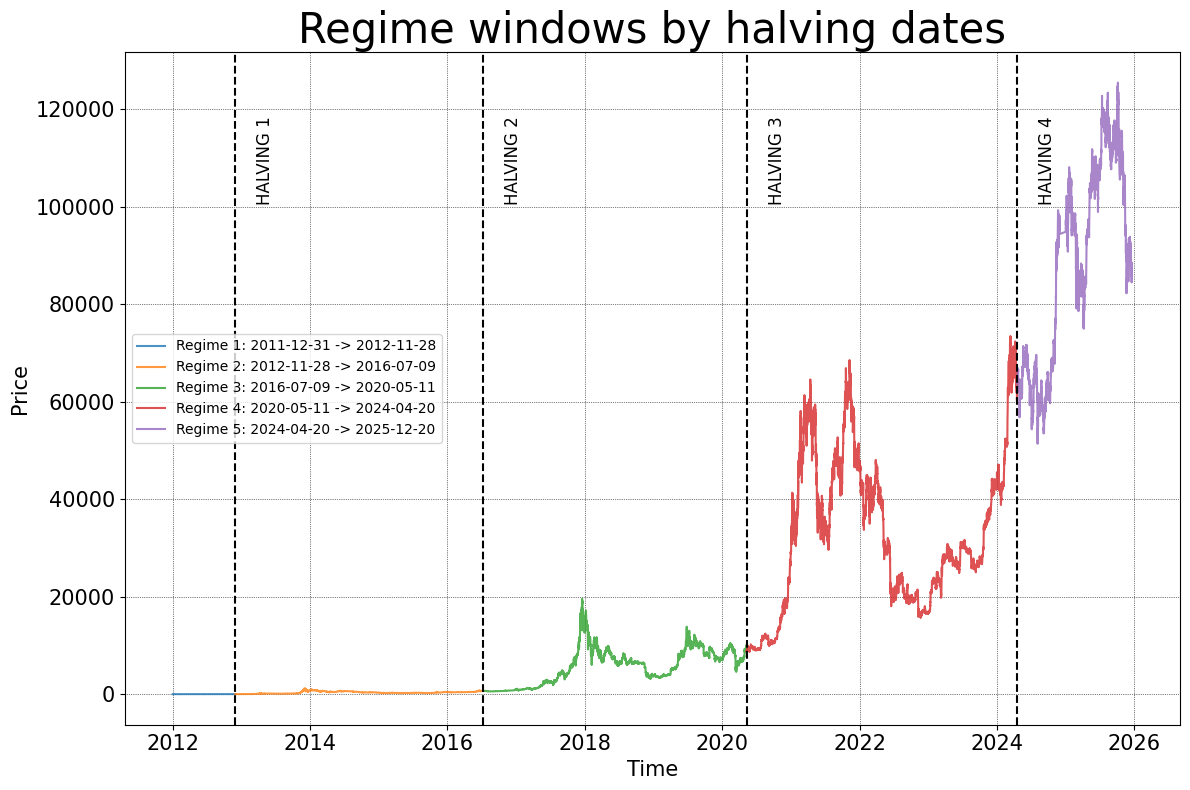

In [4]:
print("===============================")
print("STEP 1) EXPLORE DATAFRAME AND BUILD TIMESERIES")
print("===============================")

# -------------------------------
# 1. LOAD RAW DATAFRAME
# -------------------------------
log(f"LOAD RAW DATAFRAME", icon="1.", bold=True)
# Load dataframe
df_raw = pd.read_csv(raw_data_input_path, sep=raw_data_separator)
# Print raw df info
log(f"Shape of the raw DataFrame: {df_raw.shape}", level=2)
log("Preview of the raw DataFrame:", level=2)
display(df_raw.head(5))
print("\n")

# -------------------------------
# 2. EXPLORE DATAFRAME
# -------------------------------
log(f"EXPLORE DATAFRAME", icon="2.", bold=True)
# Previous data
df = df_raw.copy()
# Get time series
serie_time = pd.to_datetime(df[time_column], errors="coerce", dayfirst=day_comes_first) #'coerce': then invalid parsing will be set as NaT
# Keep only rows with valid timestamps (avoid NaT contaminating checks)
valid_mask=serie_time.notna()
df=df.loc[valid_mask].copy()
serie_time=serie_time.loc[valid_mask].copy()
# Sort by time before diff/frequency checks
order_idx=serie_time.sort_values().index
df=df.loc[order_idx].copy()
serie_time=serie_time.loc[order_idx].copy()
# Find if any time goes backwards
serie_time_diff = serie_time.diff().dropna()
bad_idx = serie_time_diff[serie_time_diff < pd.Timedelta(0)].index
# Find if any duplicated timestamps
dup_count = serie_time.duplicated().sum()
dup_times=serie_time[serie_time.duplicated(keep=False)]
# Numeric metrics
numeric_cols = df.select_dtypes(include=["number"]).columns
log(f"Numeric metrics detected: {numeric_cols}", icon="📈", level=2)
# Statistics for each metric
log("Basic statistics per numeric variable:", level=2)
display(df[numeric_cols].describe().T)
print("\n")

# -------------------------------
# 3. TIME INDEX INFORMATION
# -------------------------------
log("TIME INDEX INFORMATION", icon="3.", bold=True)
log(f"Detected time column: '{time_column}'", icon="📅", level=2)
log(f"Rows removed due to invalid timestamps (NaT): {len(df_raw)-len(df)}", icon="📅", level=2)
log(f"Start date: {serie_time.min()}", icon="📅", level=2)
log(f"End date: {serie_time.max()}", icon="📅", level=2)
log(f"Total duration: {serie_time.max() - serie_time.min()}", icon="📅", level=2)
if len(bad_idx) >0:
    log(f"Number of negative diffs: {len(bad_idx)}", icon="ERROR", level=2)
    log(f"Example indices: {bad_idx[:10].tolist()}", icon="ERROR", level=2)
    raise ValueError(f"Negative time differences found")
else:
    log("No negative diffs detected", icon="SUCCESS", level=2)
if dup_count>0:
    log(f"Number of duplicated timestamps: {dup_count}", icon="ERROR", level=2)
    log(f"Duplicated timestamps sample: {dup_times.head(10).tolist()}", icon="ERROR", level=2)
    raise ValueError(f"Duplicated timestamps found")
else:
    log("No duplicated timestamps detected", icon="SUCCESS", level=2)
print("\n")

# -------------------------------
# 4. ESTIMATE FREQUENCY AND GRANULARITY
# -------------------------------
log(f"ESTIMATE FREQUENCY AND GRANULARITY", icon="4.", bold=True)
if len(serie_time_diff) > 0:
    df_most_common_delta = serie_time_diff.mode()[0] # Most common interval
    df_smallest_delta = serie_time_diff.min() # Minimal interval
    df_freq_ratio = (serie_time_diff == df_most_common_delta).mean()
    if df_freq_ratio < 0.7:
        raise ValueError(f"Decomposition skipped due to Low frequency regularity (freq_ratio={df_freq_ratio:.3f})")
    # Determine granularity
    granularity = determine_granularity(df_most_common_delta.total_seconds())
    if granularity=="other":
        log(f"Granularity not recognized from seconds={df_most_common_delta.total_seconds()} -> period inference may fail",level=2,type="WARNING")
    log(f"Most common interval: {df_most_common_delta} ({df_most_common_delta.total_seconds()} secs) -> granularity: {granularity}", icon="📅", level=2, bold=True)
    log(f"Smallest interval: {df_smallest_delta} ({df_smallest_delta.total_seconds()} secs)", icon="📅", level=2, bold=True)
    log(f"Frequency consistency ratio: {df_freq_ratio:.8f}", icon="📅", level=2, bold=True)
else:
    log("Not enough data points to estimate frequency nor granurality", icon="ERROR", level=2)
    raise ValueError(f"Not enough data points")
# Missing or irregular timestamps
if len(serie_time_diff) > 0:
    missing_ratio = 1 - df_freq_ratio
else:
    missing_ratio = None
if missing_ratio is not None and missing_ratio > 0.10:
    log("Irregular timestamps detected (missing or uneven intervals)", level=2, type="WARNING")
    log(f"Irregularity ratio: {missing_ratio:.2f}", level=2, custom_icon="⚠️")
print("\n")

# -------------------------------
# 5. BUILD TIMESERIES + HALVING-REGIME WINDOWS
# -------------------------------
log(f"BUILD TIMESERIES + HALVING-REGIME WINDOWS", icon="5.", bold=True)
# Assign the datetime index
df.index=pd.DatetimeIndex(serie_time)
# Make sure the index has a name
df.index.name=time_column
if not df.index.is_monotonic_increasing:
    raise ValueError("Datetime index is not sorted")
if df.index.duplicated().any():
    raise ValueError("Datetime index has duplicates")
log(f"Indexed DataFrame by '{time_column}'", level=2)
# Show preview
log("Preview of time-indexed DataFrame:", level=2)
display(df.head(5))
log(f"Target column detected: '{target_column}'", level=2)
nan_target=df[target_column].isna().sum()
if nan_target>0:
    log(f"NaN values found in target '{target_column}': {nan_target} -> rows will be dropped for modeling", icon="WARNING", level=2)
else:
    log(f"None NaN values found in target '{target_column}'", icon="SUCCESS", level=2)
# Extract target timeseries
timeseries=df[target_column].dropna().astype(float)
log(f"Target column '{target_column}' ({len(timeseries)} rows) has been successfully extracted as time-series:", icon="SUCCESS", level=2)
print(timeseries[:5].to_string(dtype=False))
# Sort and convert to datetime halvings
try:
    hv_dates = pd.to_datetime(halving_dates, errors="coerce").dropna().sort_values()
except Exception as e:
    hv_dates = pd.to_datetime([], errors="coerce")
    log(f"Could not parse halving dates -> {e}", icon="WARNING", level=2)
# Build regime edges from data range + halving dates inside range
start_ts = timeseries.index.min()
end_ts = timeseries.index.max()
hv_in_range = []
for hv_date in hv_dates:
    if start_ts < hv_date < end_ts:
        hv_in_range.append(hv_date)
edges = [start_ts] + hv_in_range + [end_ts]
print("\n")

# -------------------------------
# 6. PLOT TIMESERIES WITH HALVING-REGIME WINDOWS
# -------------------------------
log("PLOT TIMESERIES WITH HALVING-REGIME WINDOWS", icon="6.", bold=True)

# Start plot
if len(edges) < 2:
    log("No valid halving boundaries inside data range -> skip timeseries with halvings plot.", icon="WARNING", level=2)
else:
    fig, ax = plt.subplots(figsize=(figWidth_unit, figHeight_unit))
    for i in range(len(edges) - 1):
        seg = timeseries.loc[edges[i]:edges[i + 1]]
        label = f"Regime {i+1}: {edges[i].date()} -> {edges[i+1].date()}"
        if len(seg) > 0:
            ax.plot(seg.index, seg.values, label=label, alpha=0.8)
    # Mark halving dates + labels
    y_top = timeseries.max()*0.8
    for i, hv_date in enumerate(hv_in_range, start=1):
        ax.axvline(x=hv_date, color="black", linewidth=1.5, linestyle="--")
        ax.text(
            hv_date, y_top,
            f"\nHALVING {i}",
            rotation=90,
            va="bottom",
            ha="left",
            fontsize=plot_label_font_size*0.8,
            color="black"
        )
    # Settings of the plot
    ax.set_title("Regime windows by halving dates", fontsize=plot_title_font_size)
    ax.set_xlabel("Time", fontsize=plot_label_font_size)
    ax.set_ylabel("Price", fontsize=plot_label_font_size)
    ax.tick_params(labelsize=plot_tick_font_size)
    ax.legend()
    ax.grid(True, linestyle="dotted", linewidth=0.5, color="black")
    plt.tight_layout()
    plt.show()

STEP 2) DECOMPOSE TIME-SERIES

STEP 2) DECOMPOSE TIME-SERIES
• 1. AUTOMATIC DETERMINATION OF SEASONAL PERIOD (m)
   - ℹ️ 1st) Trying to infer period from manual input:
      · ⚠️ No manual input was indicated for seasonal period
   - ℹ️ 2nd) Trying to infer period from acf (n=30381 | candidates=[6, 42] | threshold=0.2):
      · ℹ️ After differentiation: n=30380
      · ℹ️ Lags: max_lag=84 (cap=400)
      · ℹ️ ACF at lag m=6: -0.0484
      · ℹ️ ACF at lag m=42: 0.0010
      · ℹ️ Best candidate: m=42 -> acf=0.0010
      · ⚠️ REJECT period inference from acf (best acf=0.0010 < 0.2) -> return None
   - ℹ️ 3rd) Fallback to infer period as first candidate based on granularity
   - ✅ -> Selected seasonal period (m)=6 for '4-hour' granularity


• 2. GLOBAL SEASONALITY (ON RETURNS) (LOG-DIFF)
   - 💡 WEAK SEASONALITY detected for GLOBAL timeseries (var_ratio=0.000,acf=-0.032) -> Recommendation: try ARIMA as baseline for GLOBAL timeseries (no clear seasonality detected)


• 3. HALVING-REGIME SEASONALITY (ON RETURNS) (LOG-DIFF)

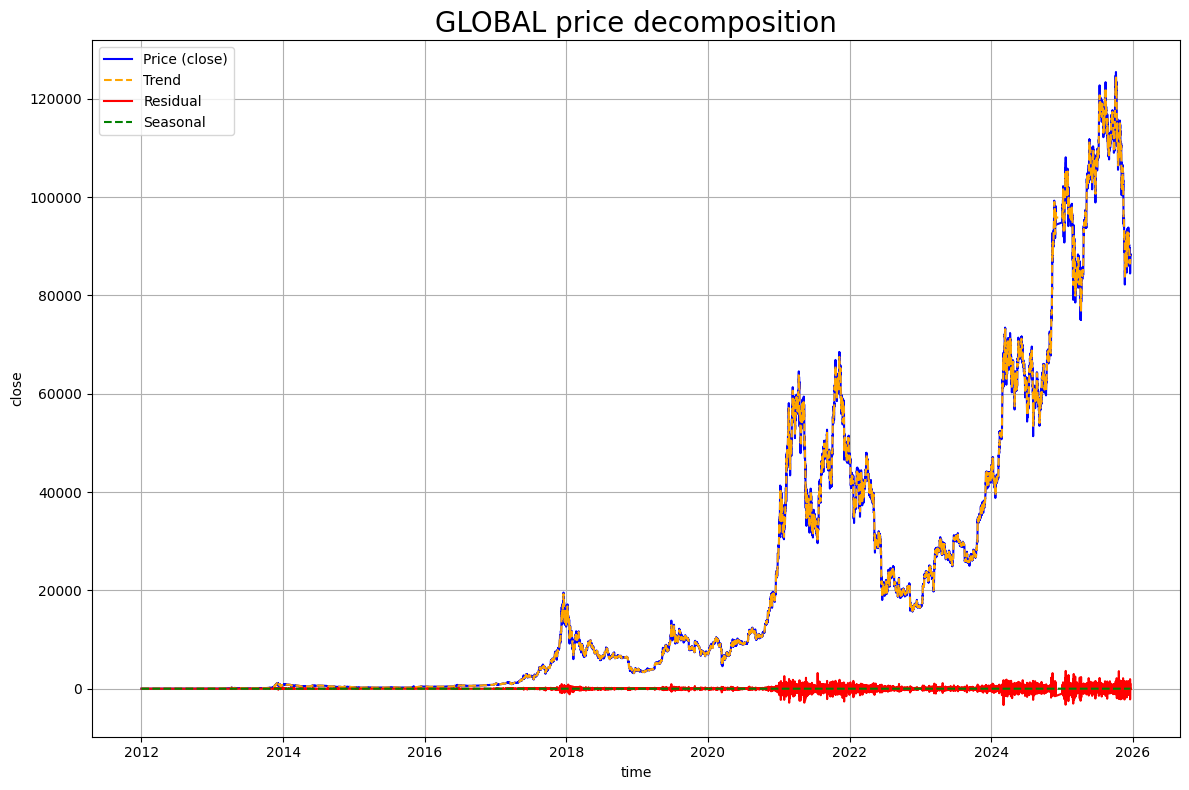



• 6.2. PRICE DECOMPOSITION (PER-REGIME)
   - ✅ Regime 1 price decomposition completed successfully


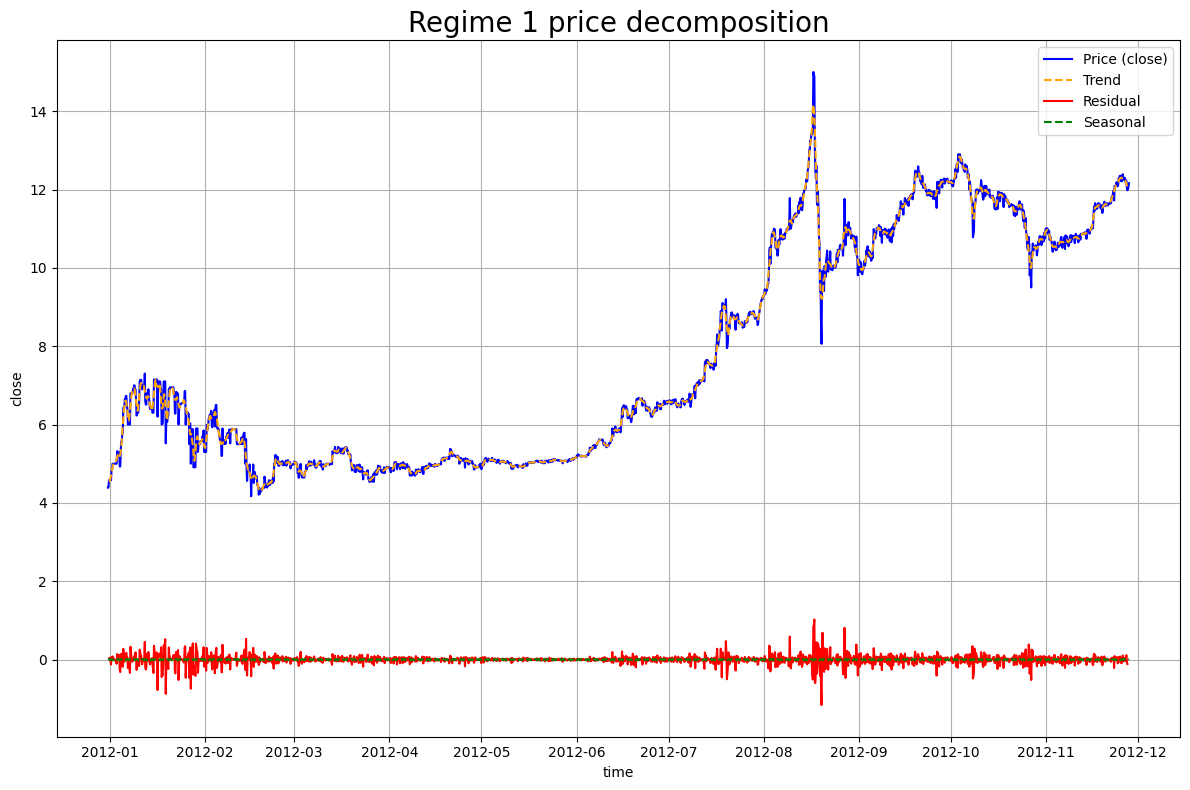

   - ✅ Regime 2 price decomposition completed successfully


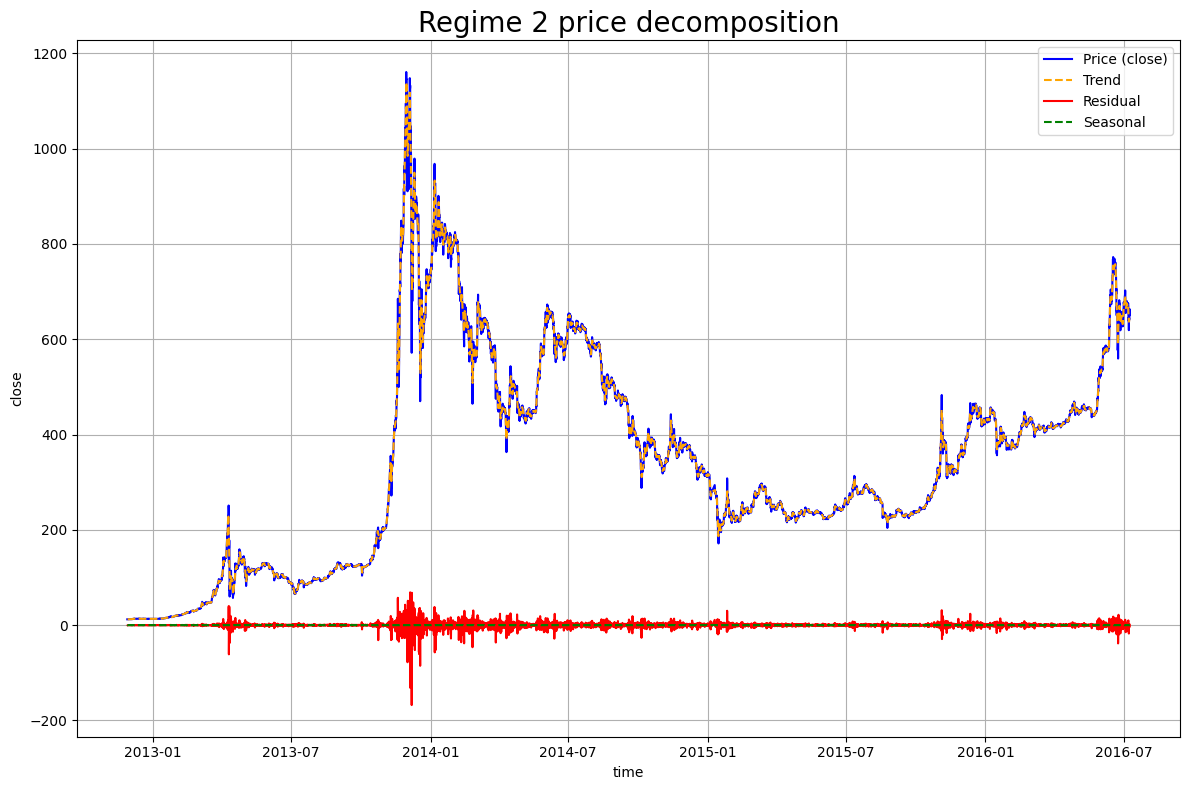

   - ✅ Regime 3 price decomposition completed successfully


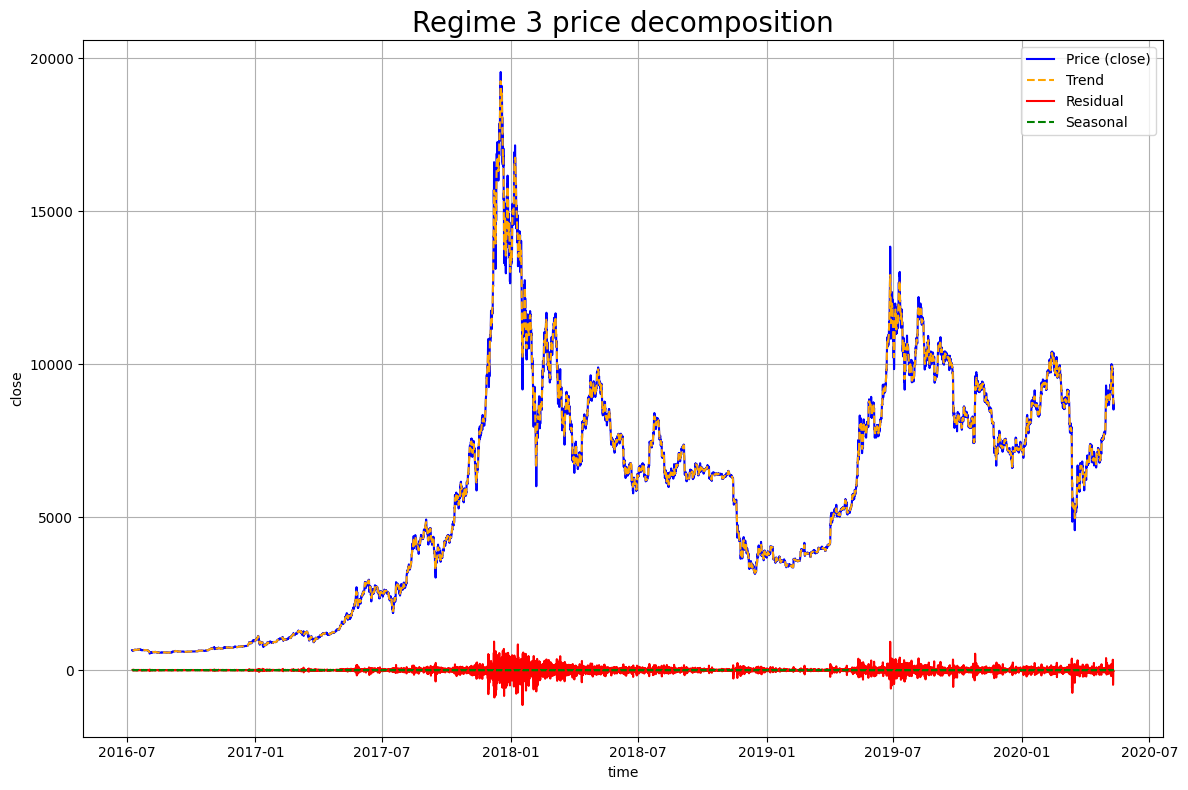

   - ✅ Regime 4 price decomposition completed successfully


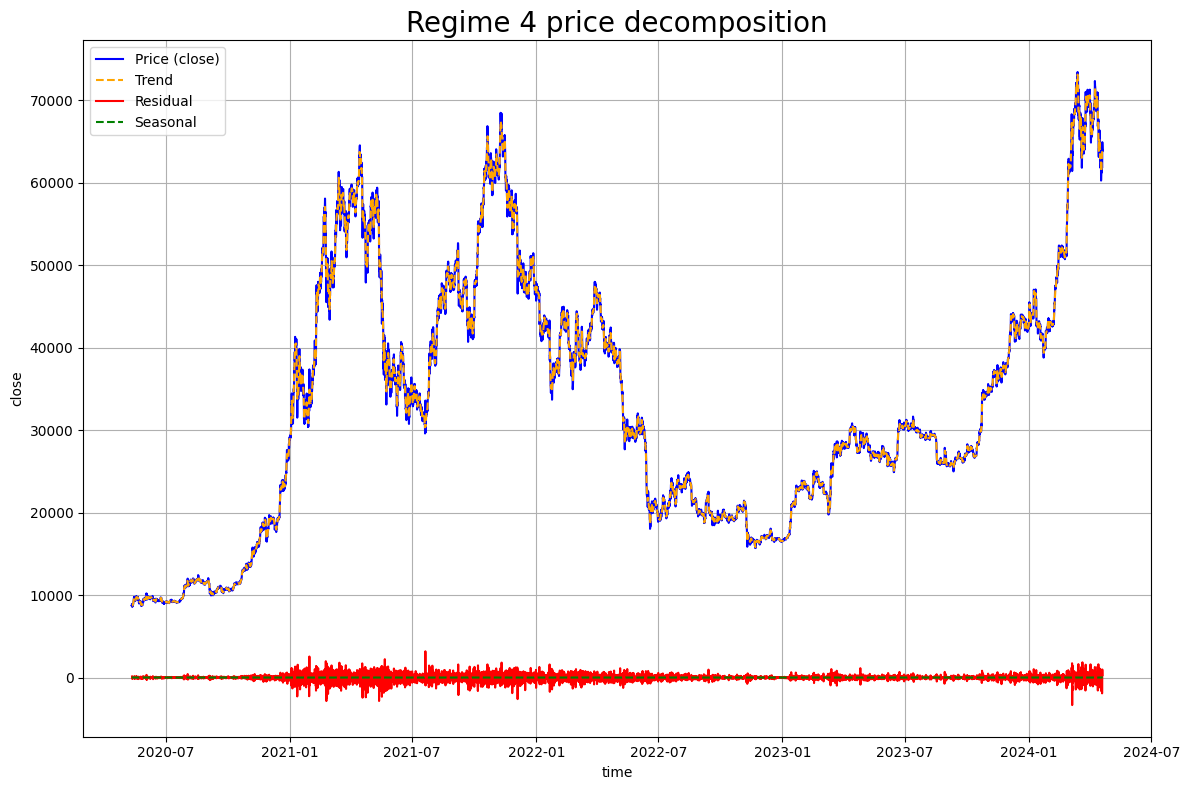

   - ✅ Regime 5 price decomposition completed successfully


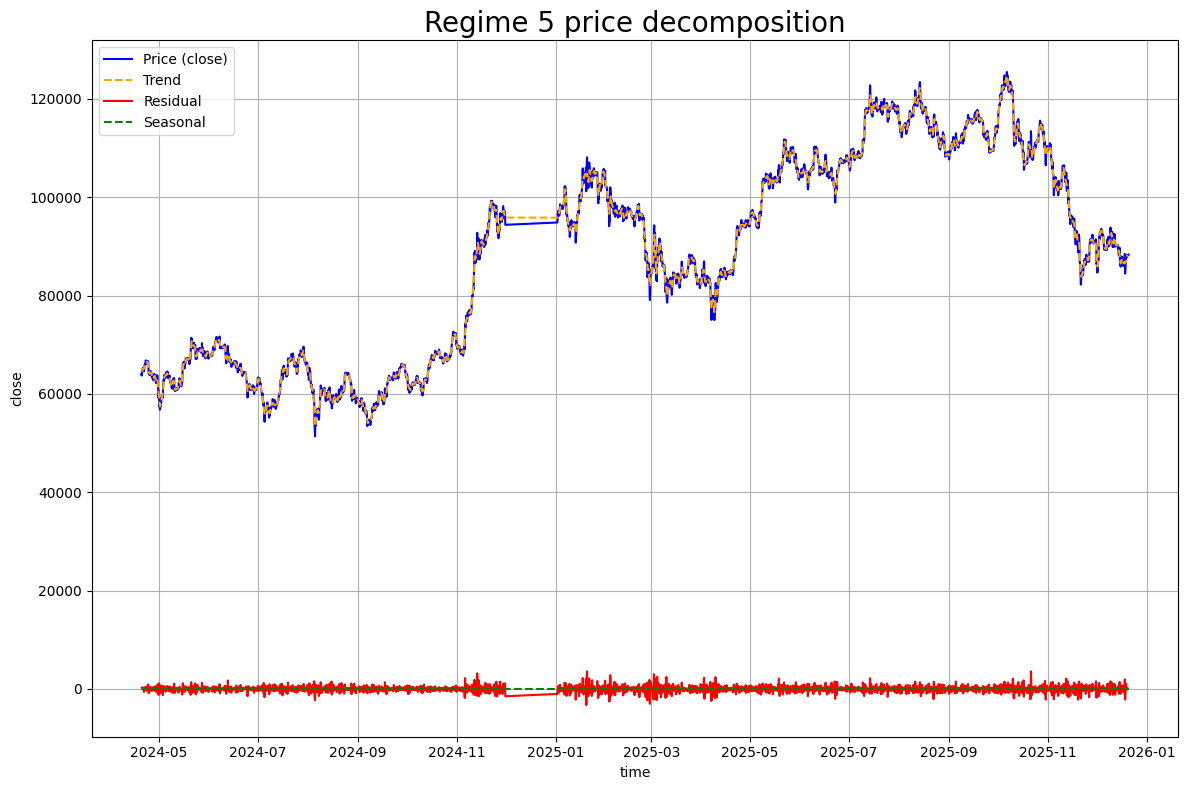

In [30]:
print("===============================")
print("STEP 2) DECOMPOSE TIME-SERIES")
print("===============================")

# -------------------------------
# 1. DETERMINE SEASONAL PERIOD (m)
# -------------------------------
log("AUTOMATIC DETERMINATION OF SEASONAL PERIOD (m)", icon="1.", bold=True)
period, period_origin = decide_seasonal_period(
    timeseries=timeseries,
    granularity=granularity,
    manual_period=seasonal_period
)
log(f"-> Selected seasonal period (m)={period} for '{granularity}' granularity", icon="SUCCESS", level=2, bold=True)
print("\n")

# -------------------------------
# 2. GLOBAL SEASONALITY (ON RETURNS)
# -------------------------------
log("GLOBAL SEASONALITY (ON RETURNS) (LOG-DIFF)", icon="2.", bold=True)
# Using returns is preferred for seasonality detection because:
# - Prices are often non-stationary (trend + unit roots).
# - Returns stabilize variance and remove trends, making seasonal structure easier to detect.
# - Seasonality in price can be distorted by long-term drift; returns isolate cyclical effects.
if len(timeseries) < period * 3:
    raise ValueError(f"Not enough samples for decomposition: n={len(timeseries)} < 3*period={period*3}")
returns = generate_returns(timeseries, method="log")
if len(returns) < period * 3:
    raise ValueError(f"Not enough samples for returns decomposition: n={len(returns)} < 3*period={period*3}")
try:
    decomposition_ret = seasonal_decompose(x=returns, model="additive", period=period)
    trend_ret = decomposition_ret.trend
    seasonal_ret = decomposition_ret.seasonal
    residual_ret = decomposition_ret.resid
except Exception as e:
    raise ValueError(f"Returns decomposition failed: {e}")
strong_seasonality_global, metrics_global = assess_seasonality_strength(
    original=returns,
    seasonal=seasonal_ret,
    period=period,
    acf_threshold=0.2,
    var_ratio=0.02
)
if strong_seasonality_global:
    log(f"STRONG SEASONALITY detected for GLOBAL timeseries (var_ratio={metrics_global['seasonal_var_ratio']:.3f},acf={metrics_global['acf_at_period']:.3f}) -> Recommendation: try SARIMA for GLOBAL timeseries with seasonal period m={period}", icon="SUGGESTION", level=2)
else:
    log(f"WEAK SEASONALITY detected for GLOBAL timeseries (var_ratio={metrics_global['seasonal_var_ratio']:.3f},acf={metrics_global['acf_at_period']:.3f}) -> Recommendation: try ARIMA as baseline for GLOBAL timeseries (no clear seasonality detected)", icon="SUGGESTION", level=2)
print("\n")

# -------------------------------
# 3) HALVING-REGIME SEASONALITY (ON RETURNS)
# -------------------------------
log("HALVING-REGIME SEASONALITY (ON RETURNS) (LOG-DIFF)", icon="3.", bold=True)
regime_metrics = []
for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)
    if len(seg) < period * 3:
        log(f"Regime {i+1} has not enough samples for decomposition: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue
    seg_returns = generate_returns(seg, method="log")
    if len(seg_returns) < period * 3:
        log(f"Regime {i+1} has not enough samples for returns decomposition: n={len(seg_returns)} < 3*period", icon="WARNING", level=2)
        continue
    try:
        dec = seasonal_decompose(x=seg_returns, model="additive", period=period)
        strong, metrics = assess_seasonality_strength(
            original=seg_returns,
            seasonal=dec.seasonal,
            period=period,
            acf_threshold=0.2,
            var_ratio=0.02
        )
        regime_metrics.append({
            "label": f"Regime {i+1}: {edges[i].date()} -> {edges[i+1].date()}",
            "n": len(seg_returns),
            "strong": strong,
            "var_ratio": metrics["seasonal_var_ratio"],
            "acf_at_period": metrics["acf_at_period"]
        })
        if strong:
            log(f"STRONG SEASONALITY detected for REGIME {i+1} ({edges[i]} - {edges[i+1]}) (var_ratio={metrics['seasonal_var_ratio']:.3f},acf={metrics['acf_at_period']:.3f}) -> Recommendation: try SARIMA for REGIME {i+1} with seasonal period m={period}", icon="SUGGESTION", level=2)
        else:
            log(f"WEAK SEASONALITY detected for REGIME {i+1} ({edges[i]} - {edges[i+1]}) (var_ratio={metrics['seasonal_var_ratio']:.3f},acf={metrics['acf_at_period']:.3f}) -> Recommendation: try ARIMA as baseline for REGIME {i+1} (no clear seasonality detected)", icon="SUGGESTION", level=2)
    except Exception as e:
        log(f"Regime {i+1} decomposition failed: {e}", icon="WARNING", level=3)
print("\n")

# -------------------------------
# 4) SEASONALITY CONSISTENCY CHECK 
# -------------------------------
log("SEASONALITY CONSISTENCY CHECK", icon="4.", bold=True)
# 1) If global seasonality is tiny, don't over-interpret regime variation
GLOBAL_WEAK_VR = 0.01   # 1% seasonal variance ratio
GLOBAL_WEAK_ACF = 0.10  # small ACF at period

global_weak = (metrics_global["seasonal_var_ratio"] < GLOBAL_WEAK_VR) and \
              (abs(metrics_global["acf_at_period"]) < GLOBAL_WEAK_ACF)

# 2) Compare each regime to global with absolute thresholds
DELTA_VR = 0.01   # absolute var_ratio change
DELTA_ACF = 0.10  # absolute ACF change

if not regime_metrics:
    log("No valid regime metrics -> default to global", icon="WARNING", level=2)
    seasonality_strategy = "global"
else:
    diffs_vr = [abs(m["var_ratio"] - metrics_global["seasonal_var_ratio"]) for m in regime_metrics]
    diffs_acf = [abs(m["acf_at_period"] - metrics_global["acf_at_period"]) for m in regime_metrics]

    frac_vr = np.mean([diffs > DELTA_VR for diffs in diffs_vr])
    frac_acf = np.mean([diffs > DELTA_ACF for diffs in diffs_acf])

    log(f"Abs deltas vs global -> var_ratio mean={np.mean(diffs_vr):.3f}, acf mean={np.mean(diffs_acf):.3f}", icon="INFO", level=2)
    log(f"Frac regimes above threshold -> var_ratio={frac_vr:.2f}, acf={frac_acf:.2f}", icon="INFO", level=2)

    if global_weak and (frac_vr < 0.25 and frac_acf < 0.25):
        log("Global seasonality is weak and regimes are similar -> GLOBAL analysis is acceptable", icon="SUCCESS", level=2)
        seasonality_strategy = "global"
    elif (frac_vr > 0.6 or frac_acf > 0.6):
        log("Large regime deviations from global -> PER_REGIME analysis seems more adequated", icon="WARNING", level=2)
        seasonality_strategy = "per_regime"
    else:
        log("Mixed signal -> use MIXED strategy", icon="INFO", level=2)
        seasonality_strategy = "mixed"
print("\n")

# -------------------------------
# 5.1) RETURN RESIDUAL DIAGNOSTICS (GLOBAL)
# -------------------------------
log("RETURN RESIDUAL DIAGNOSTICS (GLOBAL)", icon="5.1.", bold=True)
run_residual_diagnostics(residual_ret, label="GLOBAL")
print("\n")

# -------------------------------
# 5.2) RETURN RESIDUAL DIAGNOSTICS (PER-REGIME)
# -------------------------------
log("RETURN RESIDUAL DIAGNOSTICS (PER-REGIME)", icon="5.2.", bold=True)
for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)
    if len(seg) < period * 3:
        log(f"Regime {i+1} skipped: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue
    seg_returns = generate_returns(seg, method="log")
    if len(seg_returns) < period * 3:
        log(f"Regime {i+1} returns too short: n={len(seg_returns)} < 3*period", icon="WARNING", level=2)
        continue
    try:
        dec = seasonal_decompose(x=seg_returns, model="additive", period=period)
        run_residual_diagnostics(dec.resid, label=f"Regime {i+1}")
    except Exception as e:
        log(f"Regime {i+1} residual diagnostics failed: {e}", icon="WARNING", level=2)
print("\n")

# -------------------------------
# 6.1) PRICE DECOMPOSITION (GLOBAL)
# -------------------------------
log("PRICE DECOMPOSITION (GLOBAL)", icon="6.1.", bold=True)
try:
    decomposition_price = seasonal_decompose(x=timeseries, model="additive", period=period)
    trend_price = decomposition_price.trend
    seasonal_price = decomposition_price.seasonal
    residual_price = decomposition_price.resid
    log("Price decomposition completed successfully", icon="SUCCESS", level=2)
except Exception as e:
    raise ValueError(f"Price decomposition failed: {e}")

fig, axis = plt.subplots(figsize=(figWidth_unit, figHeight_unit))
sns.lineplot(data=timeseries, color="blue", label="Price (close)")
sns.lineplot(data=trend_price, color="orange", label="Trend", linestyle="--")
sns.lineplot(data=residual_price, color="red", label="Residual")
sns.lineplot(data=seasonal_price, color="green", label="Seasonal", linestyle="--")
axis.set_title(f"GLOBAL price decomposition", fontsize=plot_title_font_size)
plt.grid(True)
plt.tight_layout()
plt.show()
print("\n")

# -------------------------------
# 6.2) PRICE DECOMPOSITION (PER-REGIME)
# -------------------------------
log("PRICE DECOMPOSITION (PER-REGIME)", icon="6.2.", bold=True)
for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)

    # Require enough samples for seasonal decomposition
    if len(seg) < period * 3:
        log(f"Regime {i+1} skipped: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue

    try:
        dec_price = seasonal_decompose(x=seg, model="additive", period=period)
        trend_r = dec_price.trend
        seasonal_r = dec_price.seasonal
        residual_r = dec_price.resid
        log(f"Regime {i+1} price decomposition completed successfully", icon="SUCCESS", level=2)
    except Exception as e:
        log(f"Regime {i+1} price decomposition failed: {e}", icon="WARNING", level=2)
        continue

    fig, axis = plt.subplots(figsize=(figWidth_unit, figHeight_unit))
    sns.lineplot(data=seg, color="blue", label="Price (close)")
    sns.lineplot(data=trend_r, color="orange", label="Trend", linestyle="--")
    sns.lineplot(data=residual_r, color="red", label="Residual")
    sns.lineplot(data=seasonal_r, color="green", label="Seasonal", linestyle="--")
    axis.set_title(f"Regime {i+1} price decomposition", fontsize=plot_title_font_size)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


STEP 3) STATIONARITY (ADF) -> INFER d AND D (FOR SARIMA)

In [21]:
print("===============================")
print("STEP 3) STATIONARITY (ADF) -> INFER d (FOR ARIMA & SARIMA) AND D (FOR SARIMA)")
print("===============================")

# -------------------------------
# 1) GLOBAL STATIONARITY (ADF)
# -------------------------------
log("GLOBAL STATIONARITY (ADF) -> infer d", icon="1.", bold=True)
series_adf_base = timeseries.dropna().astype(float)
adf_base = test_stationarity(series=series_adf_base)
log("DICKEY-FULLER TEST TO DETERMINE IF BASE SERIES IS STATIONARY (GLOBAL)", icon="FOUND", level=2)
print(adf_base.to_string(dtype=False))

if adf_base["p-value"] < accepted_alpha_dickey_fuller:
    d_global = 0
    series_stationary_nonseasonal = series_adf_base
    log(f"Reject H0 at alpha={accepted_alpha_dickey_fuller}: series is stationary -> d_global={d_global}", icon="SUCCESS", level=3)
else:
    log("Fail to reject H0 -> applying recursive differencing to infer d_global", icon="WARNING", level=3)
    series_stationary_nonseasonal, d_global, adf_after_diff = make_stationary_recursive(
        series=series_adf_base, alpha=accepted_alpha_dickey_fuller
    )
    log(f"ADF after differencing (d_global={d_global})", icon="FOUND", level=2)
    display(adf_after_diff)
    if d_global > 2:
        log(f"High differencing order detected (d_global={d_global}). Consider log/returns modeling.", icon="WARNING", level=3)
    if adf_after_diff["p-value"] < accepted_alpha_dickey_fuller:
        log(f"Reject H0 after differencing -> stationary achieved with d_global={d_global}", icon="SUCCESS", level=3)
    else:
        log(f"Fail to reject H0 after differencing up to d_global={d_global}", icon="WARNING", level=3)
print("\n")

# -------------------------------
# 2) GLOBAL SEASONAL DIFFERENCING (D)
# -------------------------------
log("GLOBAL SEASONAL DIFFERENCING (D) -> infer D", icon="2.", bold=True)
D_global = 0
if period is None or period <= 1:
    log("No valid seasonal period m -> keep D_global=0", icon="WARNING", level=2)
else:
    if not strong_seasonality_global:
        log("Global seasonality is weak (STEP 2) -> keep D_global=0", icon="WARNING", level=2, bold=True)
        D_global = 0
    else:
        log("Global seasonality is strong -> evaluate D_global using ADF on d-differenced series", level=2, bold=True)
        series_for_D = series_adf_base.copy()
        if d_global > 0:
            series_for_D = series_for_D.diff(d_global).dropna()
        if len(series_for_D) < max(60, period * 5):
            log("Not enough data after differencing -> keep D_global=0", icon="WARNING", level=2)
            D_global = 0
        else:
            adf_ref = test_stationarity(series=series_for_D)
            log(f"ADF (after d_global={d_global}, no seasonal diff): {adf_ref}", level=2)
            series_for_D_seasonal = series_for_D.diff(period).dropna()
            if len(series_for_D_seasonal) < max(60, period * 5):
                log("Not enough data after seasonal diff -> keep D_global=0", icon="WARNING", level=2)
                D_global = 0
            else:
                adf_seasonal = test_stationarity(series=series_for_D_seasonal)
                log(f"ADF (after d_global={d_global} and seasonal diff): {adf_seasonal}", level=2)
                if adf_seasonal["p-value"] < accepted_alpha_dickey_fuller:
                    D_global = 1
                    log(f"Reject H0 after seasonal differencing -> suggest D_global={D_global}", icon="SUCCESS", level=2, bold=True)
                else:
                    D_global = 0
                    log(f"Fail to reject H0 -> keep D_global={D_global}", icon="WARNING", level=2, bold=True)
print("\n")

# -------------------------------
# 3) PER-REGIME STATIONARITY (ADF)
# -------------------------------
log("PER-REGIME STATIONARITY (ADF) -> infer d_regime and D_regime", icon="3.", bold=True)
regime_stationarity = []

for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)
    if len(seg) < period * 3:
        log(f"Regime {i+1} skipped: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue

    # d_regime
    adf_seg = test_stationarity(series=seg)
    if adf_seg["p-value"] < accepted_alpha_dickey_fuller:
        d_reg = 0
        seg_stationary = seg
        log(f"Regime {i+1}: stationary -> d_reg={d_reg}", icon="SUCCESS", level=2)
    else:
        seg_stationary, d_reg, adf_after = make_stationary_recursive(series=seg, alpha=accepted_alpha_dickey_fuller)
        log(f"Regime {i+1}: differenced to reach stationarity -> d_reg={d_reg}", icon="INFO", level=2)
        if d_reg > 2:
            log(f"Regime {i+1}: high differencing (d_reg={d_reg})", icon="WARNING", level=2)

    # D_regime
    D_reg = 0
    if period is None or period <= 1:
        D_reg = 0
    else:
        # Use regime-level seasonality if available
        strong_regime = None
        for m in regime_metrics:
            if m["label"].startswith(f"Regime {i+1}:"):
                strong_regime = m["strong"]
                break

        # Only evaluate seasonal differencing if regime seasonality is strong
        if strong_regime is True:
            series_for_D = seg.copy()
            if d_reg > 0:
                series_for_D = series_for_D.diff(d_reg).dropna()
            if len(series_for_D) < max(60, period * 5):
                D_reg = 0
            else:
                series_for_D_seasonal = series_for_D.diff(period).dropna()
                if len(series_for_D_seasonal) < max(60, period * 5):
                    D_reg = 0
                else:
                    adf_seasonal = test_stationarity(series=series_for_D_seasonal)
                    if adf_seasonal["p-value"] < accepted_alpha_dickey_fuller:
                        D_reg = 1
        else:
            D_reg = 0

    regime_stationarity.append({
        "label": f"Regime {i+1}: {edges[i].date()} -> {edges[i+1].date()}",
        "d_reg": d_reg,
        "D_reg": D_reg
    })
    log(f"Regime {i+1}: d_reg={d_reg}, D_reg={D_reg}", icon="INFO", level=2)

print("\n")

# -------------------------------
# 4) MODELS PARAMETERS RECOMMENDATION
# -------------------------------
log("MODELS PARAMETERS RECOMMENDATION", icon="4.", bold=True)
log(f"GLOBAL -> ARIMA d={d_global} | SARIMA D={D_global}, m={period}", icon="SUGGESTION", level=2, bold=True)
if regime_stationarity:
    for r in regime_stationarity:
        log(f"{r['label']} -> ARIMA d={r['d_reg']} | SARIMA D={r['D_reg']}, m={period}", icon="SUGGESTION", level=2)

STEP 3) STATIONARITY (ADF) -> INFER d (FOR ARIMA & SARIMA) AND D (FOR SARIMA)
• 1. GLOBAL STATIONARITY (ADF) -> infer d
   - 🔍 DICKEY-FULLER TEST TO DETERMINE IF BASE SERIES IS STATIONARY (GLOBAL)
Test Statistic                    -0.079639
p-value                            0.951429
#Lags Used                        49.000000
Number of Observations Used    30331.000000
Critical Value (1%)               -3.430566
Critical Value (5%)               -2.861635
Critical Value (10%)              -2.566821
      · ⚠️ Fail to reject H0 -> applying recursive differencing to infer d_global
   - 🔍 ADF after differencing (d_global=1)


Test Statistic                   -25.550945
p-value                            0.000000
#Lags Used                        48.000000
Number of Observations Used    30331.000000
Critical Value (1%)               -3.430566
Critical Value (5%)               -2.861635
Critical Value (10%)              -2.566821
dtype: float64

      · ✅ Reject H0 after differencing -> stationary achieved with d_global=1


• 2. GLOBAL SEASONAL DIFFERENCING (D) -> infer D
   - ⚠️ Global seasonality is weak (STEP 2) -> keep D_global=0


• 3. PER-REGIME STATIONARITY (ADF) -> infer d_regime and D_regime
   - ℹ️ Regime 1: differenced to reach stationarity -> d_reg=1
   - ℹ️ Regime 1: d_reg=1, D_reg=0
   - ℹ️ Regime 2: differenced to reach stationarity -> d_reg=1
   - ℹ️ Regime 2: d_reg=1, D_reg=0
   - ℹ️ Regime 3: differenced to reach stationarity -> d_reg=1
   - ℹ️ Regime 3: d_reg=1, D_reg=0
   - ℹ️ Regime 4: differenced to reach stationarity -> d_reg=1
   - ℹ️ Regime 4: d_reg=1, D_reg=0
   - ℹ️ Regime 5: differenced to reach stationarity -> d_reg=1
   - ℹ️ Regime 5: d_reg=1, D_reg=0


• 4. MODELS PARAMETERS RECOMMENDATION
   - 💡 GLOBAL -> ARIMA d=1 | SARIMA D=0, m=6
   - 💡 Regime 1: 2011-12-31 -> 2012-11-28 -> ARIMA d=1 | SARIMA D=0, m=6
   - 💡 Regime 2: 2012-11-28 -> 2016-07-09 -> ARIMA d=1 | SARIMA D=0, m=6
   - 💡 Regime 3: 20

STEP 4) ACF/PACF DIAGNOSTICS + ORDER SUGGESTIONS (ARIMA vs SARIMA)

STEP 4) ACF/PACF DIAGNOSTICS + ORDER SUGGESTIONS (GLOBAL + REGIME)
• 1. PREPARE GLOBAL DIAGNOSTICS SERIES
   - ✅ Applied pandas frequency '4h' for diagnostics.
   - ℹ️ Diagnostics series prepared with non-seasonal differencing d_global=1 (n=30373)
• 2. GLOBAL NON-SEASONAL ACF/PACF -> suggest p/q
   - ℹ️ Using safe_lag=42 (n=30373, conf~=+/-0.011)
   - ℹ️ ACF -> q~1
   - ℹ️ PACF -> p~1


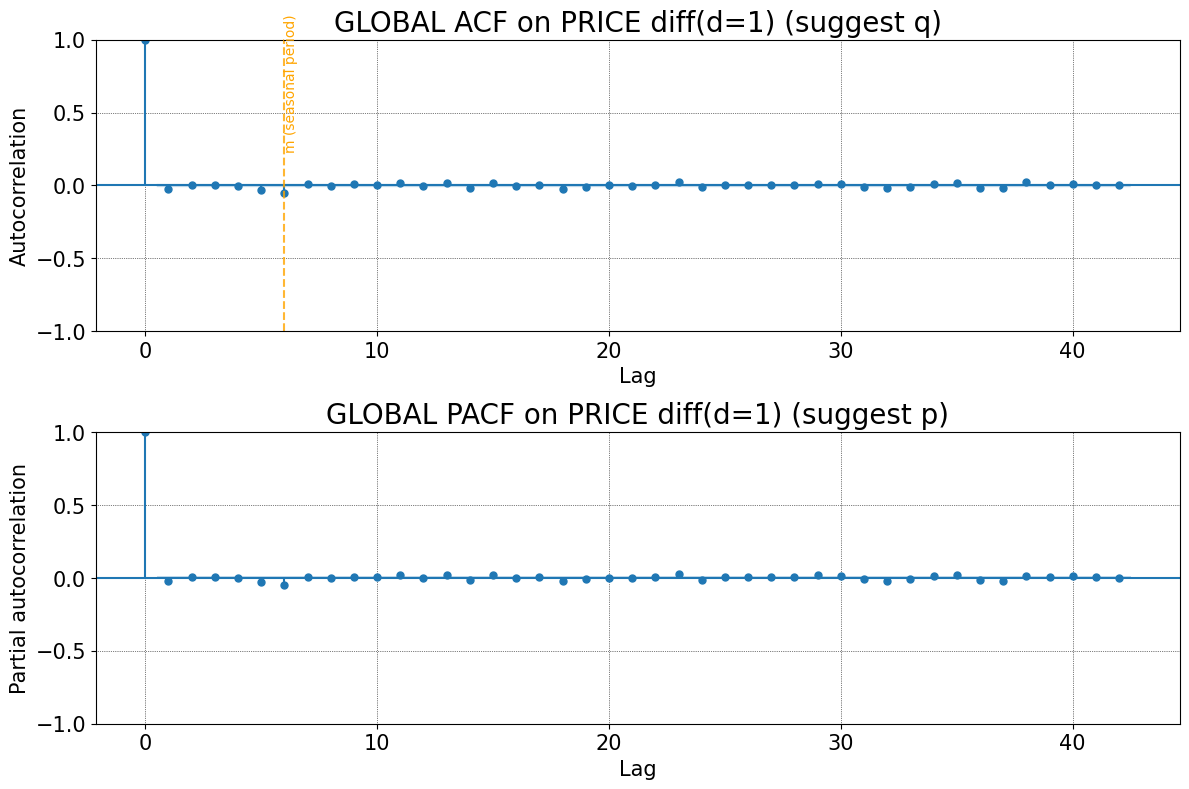

• 3. GLOBAL SEASONAL ACF/PACF -> suggest P/Q
   - ℹ️ Seasonal diagnostics series prepared with D_global=0 and m=6 (n=30373)
   - ℹ️ Seasonal ACF -> Q~1
   - ℹ️ Seasonal PACF -> P~1


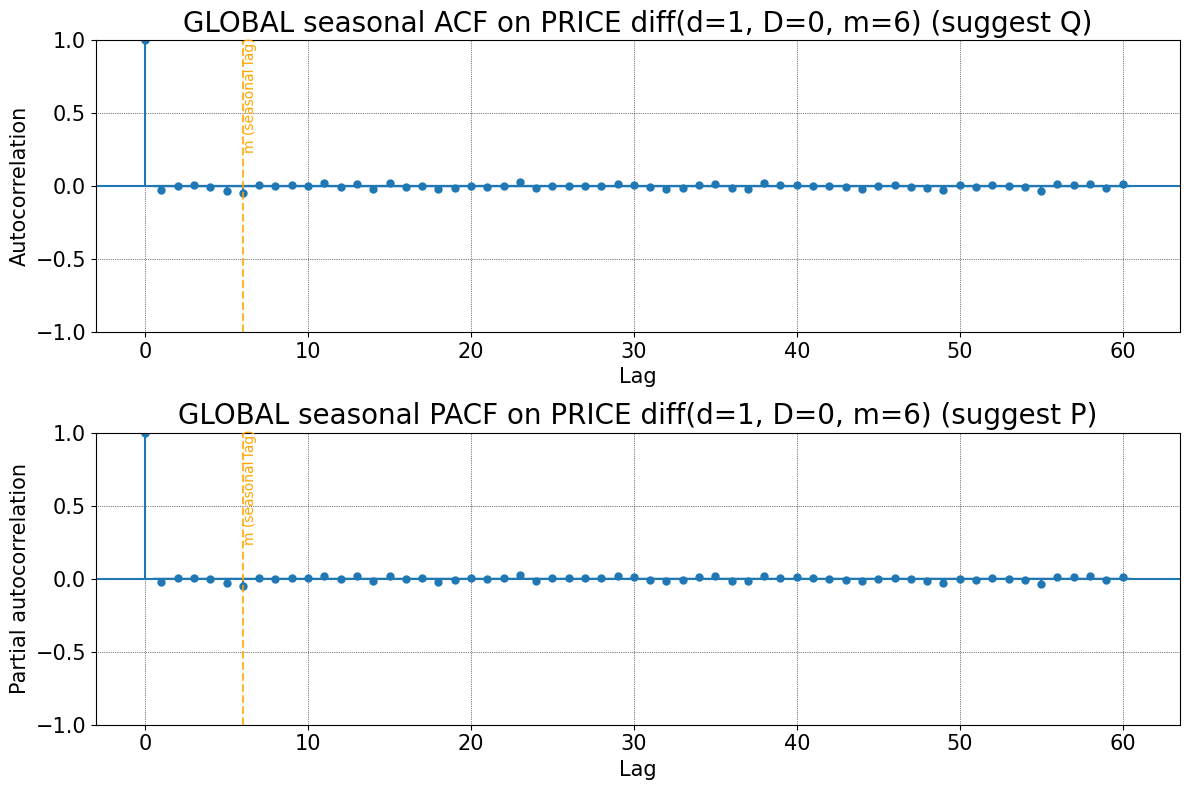

• 4. GLOBAL AIC/BIC GRID CHECK (sanity)
   - ℹ️ Top ARIMA by AIC: (p,d,q)=(0,1,1) | AIC=451697.17 BIC=451713.83; (p,d,q)=(1,1,1) | AIC=451698.78 BIC=451723.77; (p,d,q)=(1,1,0) | AIC=451710.90 BIC=451727.56; (p,d,q)=(0,1,0) | AIC=451726.60 BIC=451734.93
   - ℹ️ Top ARIMA by BIC: (p,d,q)=(0,1,1) | AIC=451697.17 BIC=451713.83; (p,d,q)=(1,1,1) | AIC=451698.78 BIC=451723.77; (p,d,q)=(1,1,0) | AIC=451710.90 BIC=451727.56; (p,d,q)=(0,1,0) | AIC=451726.60 BIC=451734.93
   - ⚠️ SARIMA grid skipped: weak/invalid seasonality
• 5. PER-REGIME ACF/PACF + GRIDS (NON-SEASONAL + SEASONAL)


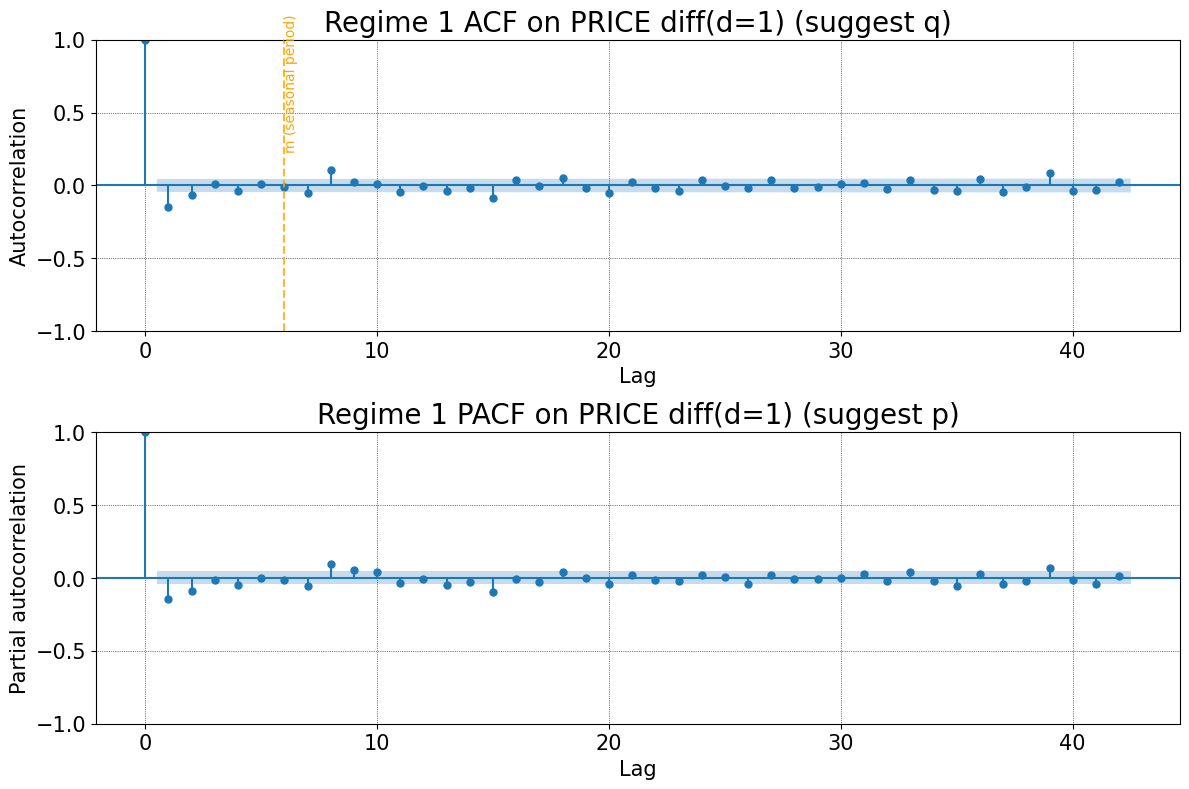

   - ℹ️ Regime 1: p~1, q~1, d=1, D=0
   - ℹ️ Regime 1 ARIMA grid size=4 -> examples: [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)]
   - ℹ️ Regime 1 SARIMA grid size=16 -> examples: [(0, 1, 0, 0, 0, 0, 6), (0, 1, 0, 0, 0, 1, 6), (0, 1, 0, 1, 0, 0, 6), (0, 1, 0, 1, 0, 1, 6), (0, 1, 1, 0, 0, 0, 6), (0, 1, 1, 0, 0, 1, 6)]


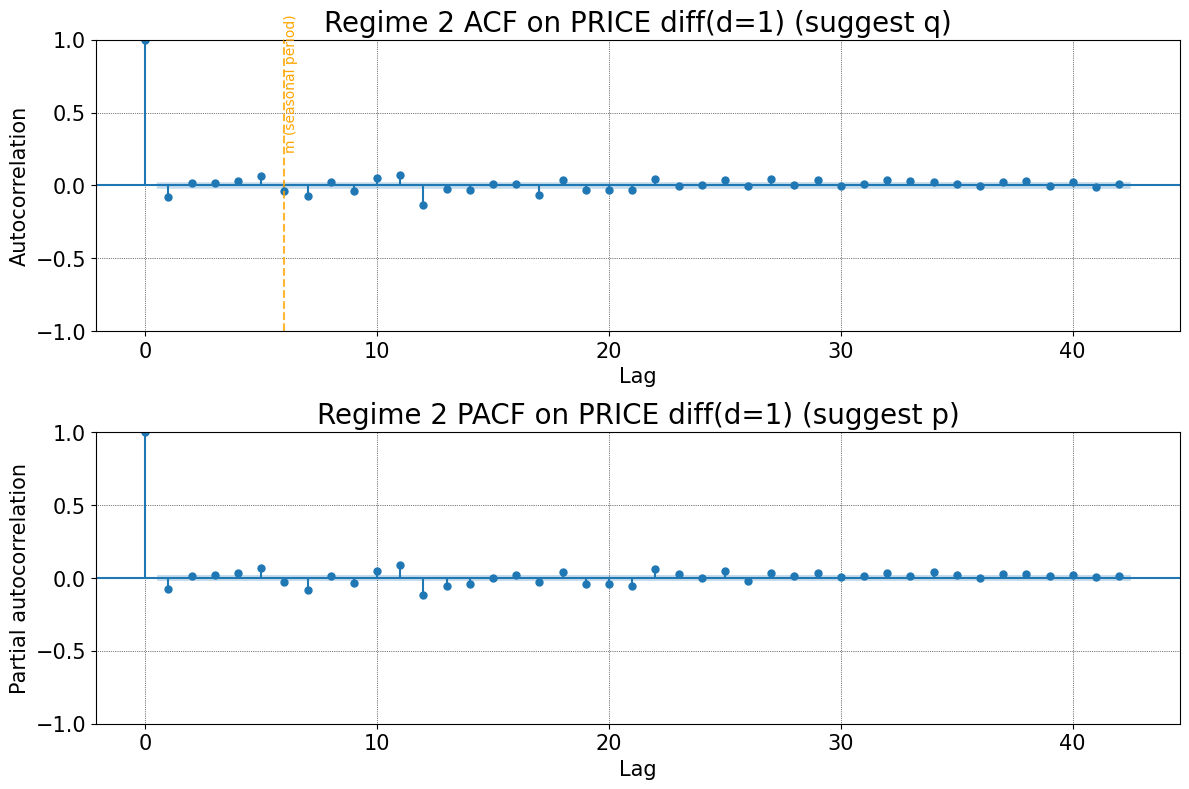

   - ℹ️ Regime 2: p~1, q~1, d=1, D=0
   - ℹ️ Regime 2 ARIMA grid size=4 -> examples: [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)]
   - ℹ️ Regime 2 SARIMA grid size=16 -> examples: [(0, 1, 0, 0, 0, 0, 6), (0, 1, 0, 0, 0, 1, 6), (0, 1, 0, 1, 0, 0, 6), (0, 1, 0, 1, 0, 1, 6), (0, 1, 1, 0, 0, 0, 6), (0, 1, 1, 0, 0, 1, 6)]


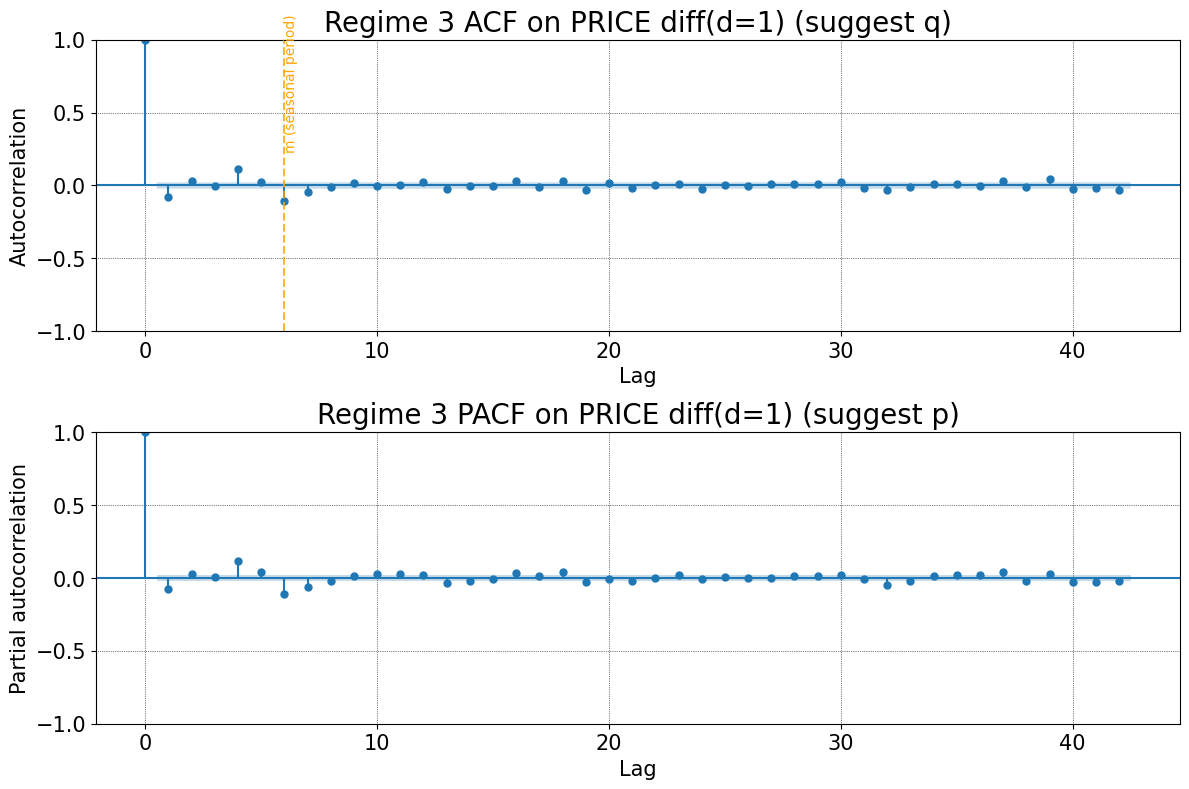

   - ℹ️ Regime 3: p~1, q~1, d=1, D=0
   - ℹ️ Regime 3 ARIMA grid size=4 -> examples: [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)]
   - ℹ️ Regime 3 SARIMA grid size=16 -> examples: [(0, 1, 0, 0, 0, 0, 6), (0, 1, 0, 0, 0, 1, 6), (0, 1, 0, 1, 0, 0, 6), (0, 1, 0, 1, 0, 1, 6), (0, 1, 1, 0, 0, 0, 6), (0, 1, 1, 0, 0, 1, 6)]


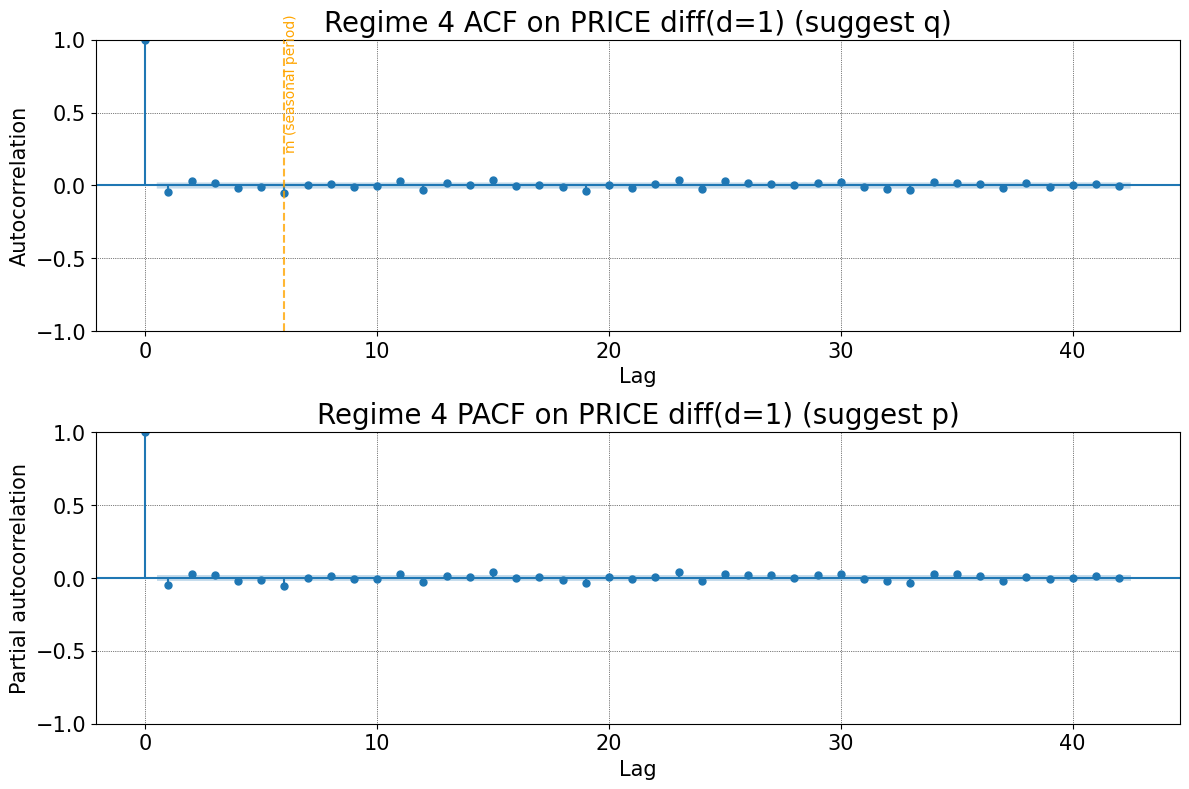

   - ℹ️ Regime 4: p~1, q~1, d=1, D=0
   - ℹ️ Regime 4 ARIMA grid size=4 -> examples: [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)]
   - ℹ️ Regime 4 SARIMA grid size=16 -> examples: [(0, 1, 0, 0, 0, 0, 6), (0, 1, 0, 0, 0, 1, 6), (0, 1, 0, 1, 0, 0, 6), (0, 1, 0, 1, 0, 1, 6), (0, 1, 1, 0, 0, 0, 6), (0, 1, 1, 0, 0, 1, 6)]


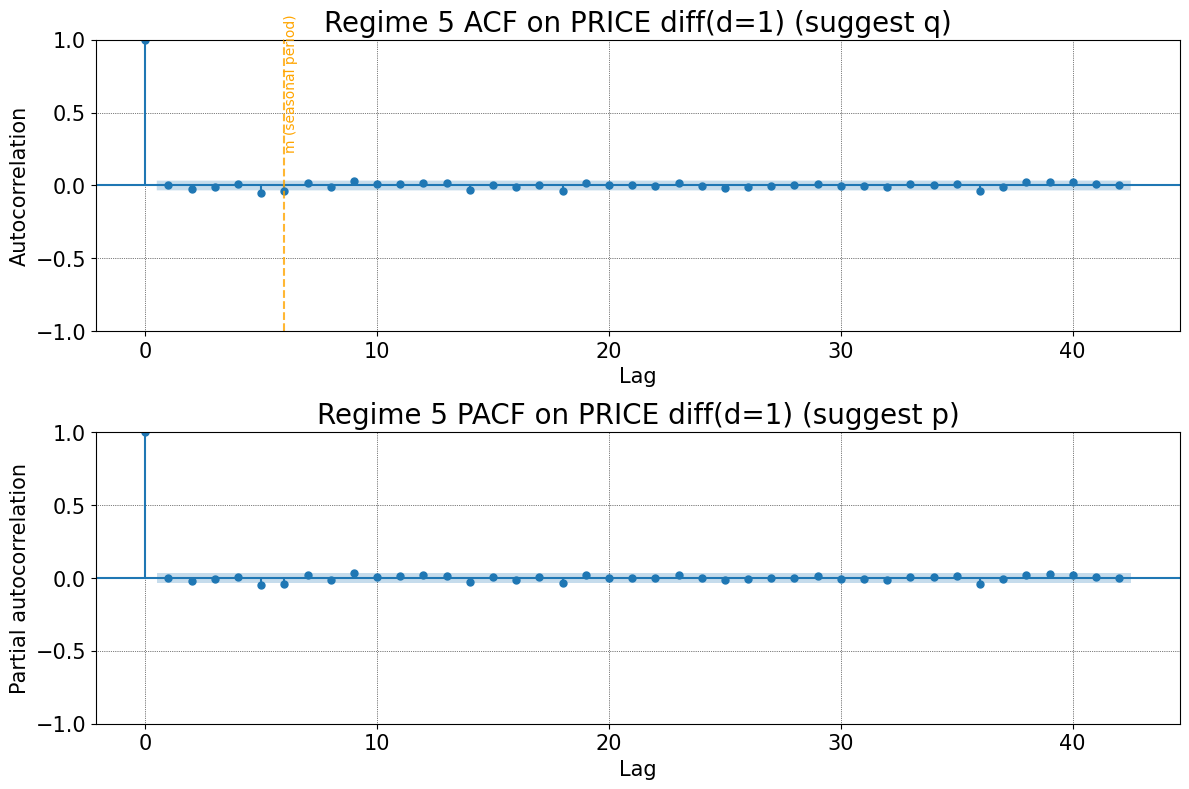

   - ℹ️ Regime 5: p~5, q~5, d=1, D=0
   - ℹ️ Regime 5 ARIMA grid size=9 -> examples: [(0, 1, 0), (0, 1, 1), (0, 1, 5), (1, 1, 0), (1, 1, 1), (1, 1, 5)]
   - ℹ️ Regime 5 SARIMA grid size=36 -> examples: [(0, 1, 0, 0, 0, 0, 6), (0, 1, 0, 0, 0, 1, 6), (0, 1, 0, 1, 0, 0, 6), (0, 1, 0, 1, 0, 1, 6), (0, 1, 1, 0, 0, 0, 6), (0, 1, 1, 0, 0, 1, 6)]


• 6. ORDER SUGGESTIONS SUMMARY (GLOBAL)
   - ℹ️ ARIMA suggestion: (p,d,q)=(1,1,1)
   - ℹ️ SARIMA suggestion: (p,d,q)(P,D,Q,m)=(1,1,1)(1,0,1,6)
   - ℹ️ GLOBAL ARIMA grid size=4 -> examples: [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)]
   - ℹ️ GLOBAL SARIMA grid size=16 -> examples: [(0, 1, 0, 0, 0, 0, 6), (0, 1, 0, 0, 0, 1, 6), (0, 1, 0, 1, 0, 0, 6), (0, 1, 0, 1, 0, 1, 6), (0, 1, 1, 0, 0, 0, 6), (0, 1, 1, 0, 0, 1, 6), (0, 1, 1, 1, 0, 0, 6), (0, 1, 1, 1, 0, 1, 6)]


In [34]:
# ===============================
# STEP 4) ACF/PACF DIAGNOSTICS + ORDER SUGGESTIONS (GLOBAL + REGIME)
# ===============================
print("===============================")
print("STEP 4) ACF/PACF DIAGNOSTICS + ORDER SUGGESTIONS (GLOBAL + REGIME)")
print("===============================")

# -------------------------------
# 1) PREPARE GLOBAL DIAGNOSTICS SERIES
# -------------------------------
log("PREPARE GLOBAL DIAGNOSTICS SERIES", icon="1.", bold=True)
series_for_diag = timeseries.dropna().astype(float).copy()
freq = get_pandas_freq_from_granularity(granularity)
if freq is not None:
    try:
        series_for_diag = series_for_diag.asfreq(freq)
        log(f"Applied pandas frequency '{freq}' for diagnostics.", icon="SUCCESS", level=2)
    except Exception as e:
        log(f"Could not apply pandas frequency '{freq}': {e}", icon="WARNING", level=2)
else:
    log(f"No pandas freq mapping for granularity='{granularity}' -> skipping asfreq.", icon="WARNING", level=2)

series_diag_ns = series_for_diag.copy()
if d_global > 0:
    series_diag_ns = series_diag_ns.diff(d_global).dropna()
log(f"Diagnostics series prepared with non-seasonal differencing d_global={d_global} (n={len(series_diag_ns)})", icon="INFO", level=2)

# Default suggestions (global)
suggested_p = 0
suggested_q = 0
suggested_P = 0
suggested_Q = 0

# -------------------------------
# 2) GLOBAL NON-SEASONAL ACF/PACF -> suggest (p, q)
# -------------------------------
log("GLOBAL NON-SEASONAL ACF/PACF -> suggest p/q", icon="2.", bold=True)
if len(series_diag_ns) < 30 or series_diag_ns.std() < 1e-8:
    log("ACF/PACF: series too short or almost constant -> p=q=0", icon="WARNING", level=2)
else:
    n = len(series_diag_ns)
    safe_lag = get_safe_lag_for_acf_pacf(granularity, period, n, max_cap=300)
    conf_limit = 1.96 / np.sqrt(n)
    log(f"Using safe_lag={safe_lag} (n={n}, conf~=+/-{conf_limit:.3f})", icon="INFO", level=2)

    ac_vals = acf(series_diag_ns, nlags=safe_lag, fft=True, missing="drop")
    pc_vals = pacf(series_diag_ns, nlags=safe_lag, method="ywm")

    sig_acf = [lag for lag in range(1, len(ac_vals)) if abs(ac_vals[lag]) > conf_limit]
    sig_pacf = [lag for lag in range(1, len(pc_vals)) if abs(pc_vals[lag]) > conf_limit]

    suggested_q = int(sig_acf[0]) if sig_acf else 0
    suggested_p = int(sig_pacf[0]) if sig_pacf else 0
    log(f"ACF -> q~{suggested_q}", icon="INFO", level=2)
    log(f"PACF -> p~{suggested_p}", icon="INFO", level=2)

    # Global ACF/PACF (2 rows, 1 column)
    fig, axes = plt.subplots(2, 1, figsize=(figWidth_unit, figHeight_unit))
    plot_acf(series_diag_ns, lags=safe_lag, ax=axes[0])
    axes[0].set_title(f"GLOBAL ACF on PRICE diff(d={d_global}) (suggest q)", fontsize=plot_title_font_size)
    axes[0].set_xlabel("Lag", fontsize=plot_label_font_size)
    axes[0].set_ylabel("Autocorrelation", fontsize=plot_label_font_size)
    axes[0].tick_params(labelsize=plot_tick_font_size)
    axes[0].grid(True, linestyle="dotted", linewidth=0.5, color="black")
    if period is not None and period > 1 and period <= safe_lag:
        axes[0].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
        axes[0].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal period)", rotation=90, color="orange")

    plot_pacf(series_diag_ns, lags=safe_lag, ax=axes[1], method="ywm")
    axes[1].set_title(f"GLOBAL PACF on PRICE diff(d={d_global}) (suggest p)", fontsize=plot_title_font_size)
    axes[1].set_xlabel("Lag", fontsize=plot_label_font_size)
    axes[1].set_ylabel("Partial autocorrelation", fontsize=plot_label_font_size)
    axes[1].tick_params(labelsize=plot_tick_font_size)
    axes[1].grid(True, linestyle="dotted", linewidth=0.5, color="black")
    plt.tight_layout()
    plt.show()

# -------------------------------
# 3) GLOBAL SEASONAL ACF/PACF -> suggest (P, Q)
# -------------------------------
log("GLOBAL SEASONAL ACF/PACF -> suggest P/Q", icon="3.", bold=True)
if period is None or period <= 1:
    log("Seasonal order suggestion skipped: invalid seasonal period m.", icon="WARNING", level=2)
else:
    series_diag_s = series_diag_ns.copy()
    if D_global > 0:
        series_diag_s = series_diag_s.diff(period).dropna()
    log(f"Seasonal diagnostics series prepared with D_global={D_global} and m={period} (n={len(series_diag_s)})", icon="INFO", level=2)

    if len(series_diag_s) < max(60, period * 5):
        log("Not enough points for seasonal ACF/PACF -> keep P=0,Q=0", icon="WARNING", level=2)
    else:
        safe_lag_s = int(min(max(2 * period, 60), len(series_diag_s) - 2, 400))
        conf_limit_s = 1.96 / np.sqrt(len(series_diag_s))

        ac_s = acf(series_diag_s, nlags=safe_lag_s, fft=True, missing="drop")
        pc_s = pacf(series_diag_s, nlags=safe_lag_s, method="ywm")

        seasonal_lags = [k * period for k in range(1, (safe_lag_s // period) + 1)]
        sig_seasonal_acf = [L for L in seasonal_lags if L < len(ac_s) and abs(ac_s[L]) > conf_limit_s]
        sig_seasonal_pacf = [L for L in seasonal_lags if L < len(pc_s) and abs(pc_s[L]) > conf_limit_s]

        suggested_Q = 1 if sig_seasonal_acf else 0
        suggested_P = 1 if sig_seasonal_pacf else 0
        log(f"Seasonal ACF -> Q~{suggested_Q}", icon="INFO", level=2)
        log(f"Seasonal PACF -> P~{suggested_P}", icon="INFO", level=2)

        # Global seasonal ACF/PACF (2 rows, 1 column)
        fig, axes = plt.subplots(2, 1, figsize=(figWidth_unit, figHeight_unit))
        plot_acf(series_diag_s, lags=safe_lag_s, ax=axes[0])
        axes[0].set_title(f"GLOBAL seasonal ACF on PRICE diff(d={d_global}, D={D_global}, m={period}) (suggest Q)", fontsize=plot_title_font_size)
        axes[0].set_xlabel("Lag", fontsize=plot_label_font_size)
        axes[0].set_ylabel("Autocorrelation", fontsize=plot_label_font_size)
        axes[0].tick_params(labelsize=plot_tick_font_size)
        axes[0].grid(True, linestyle="dotted", linewidth=0.5, color="black")
        axes[0].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
        axes[0].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal lag)", rotation=90, color="orange")

        plot_pacf(series_diag_s, lags=safe_lag_s, ax=axes[1], method="ywm")
        axes[1].set_title(f"GLOBAL seasonal PACF on PRICE diff(d={d_global}, D={D_global}, m={period}) (suggest P)", fontsize=plot_title_font_size)
        axes[1].set_xlabel("Lag", fontsize=plot_label_font_size)
        axes[1].set_ylabel("Partial autocorrelation", fontsize=plot_label_font_size)
        axes[1].tick_params(labelsize=plot_tick_font_size)
        axes[1].grid(True, linestyle="dotted", linewidth=0.5, color="black")
        axes[1].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
        axes[1].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal lag)", rotation=90, color="orange")
        plt.tight_layout()
        plt.show()

# -------------------------------
# 4) GLOBAL AIC/BIC GRID CHECK (sanity only)
# -------------------------------
log("GLOBAL AIC/BIC GRID CHECK (sanity)", icon="4.", bold=True)
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    _SARIMAX_OK = True
except Exception as e:
    _SARIMAX_OK = False
    log(f"SARIMAX import failed -> skip AIC/BIC grid ({e})", icon="WARNING", level=2)

if _SARIMAX_OK:
    p_cands = sorted(list(set([0, 1, suggested_p])))
    q_cands = sorted(list(set([0, 1, suggested_q])))
    P_cands = sorted(list(set([0, 1, suggested_P])))
    Q_cands = sorted(list(set([0, 1, suggested_Q])))

    arima_scores = []
    for p_try in p_cands:
        for q_try in q_cands:
            try:
                res = SARIMAX(endog=series_for_diag, order=(p_try, d_global, q_try),
                              seasonal_order=(0, 0, 0, 0),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                arima_scores.append((p_try, d_global, q_try, res.aic, res.bic))
            except Exception as e:
                log(f"ARIMA({p_try},{d_global},{q_try}) failed: {e}", icon="WARNING", level=2)

    if arima_scores:
        arima_by_aic = sorted(arima_scores, key=lambda x: x[3])[:5]
        arima_by_bic = sorted(arima_scores, key=lambda x: x[4])[:5]

        def fmt_arima(rows):
            return "; ".join([f"(p,d,q)=({p},{d},{q}) | AIC={aic:.2f} BIC={bic:.2f}" for p,d,q,aic,bic in rows])

        log(f"Top ARIMA by AIC: {fmt_arima(arima_by_aic)}", icon="INFO", level=2)
        log(f"Top ARIMA by BIC: {fmt_arima(arima_by_bic)}", icon="INFO", level=2)

    if period is None or period <= 1 or not strong_seasonality_global:
        log("SARIMA grid skipped: weak/invalid seasonality", icon="WARNING", level=2)
    else:
        sarima_scores = []
        for p_try in p_cands:
            for q_try in q_cands:
                for P_try in P_cands:
                    for Q_try in Q_cands:
                        try:
                            res = SARIMAX(endog=series_for_diag, order=(p_try, d_global, q_try),
                                          seasonal_order=(P_try, D_global, Q_try, period),
                                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                            sarima_scores.append((p_try, d_global, q_try, P_try, D_global, Q_try, period, res.aic, res.bic))
                        except Exception as e:
                            log(f"SARIMA({p_try},{d_global},{q_try})({P_try},{D_global},{Q_try},{period}) failed: {e}", icon="WARNING", level=2)

        if sarima_scores:
            sarima_by_aic = sorted(sarima_scores, key=lambda x: x[7])[:5]
            sarima_by_bic = sorted(sarima_scores, key=lambda x: x[8])[:5]

            def fmt_sarima(rows):
                return "; ".join([f"(p,d,q)=({p},{d},{q}) (P,D,Q,m)=({P},{D},{Q},{m}) | AIC={aic:.2f} BIC={bic:.2f}"
                                  for p,d,q,P,D,Q,m,aic,bic in rows])

            log(f"Top SARIMA by AIC: {fmt_sarima(sarima_by_aic)}", icon="INFO", level=2)
            log(f"Top SARIMA by BIC: {fmt_sarima(sarima_by_bic)}", icon="INFO", level=2)

# -------------------------------
# 5) PER-REGIME DIAGNOSTICS + GRIDS (NON-SEASONAL + SEASONAL)
# -------------------------------
log("PER-REGIME ACF/PACF + GRIDS (NON-SEASONAL + SEASONAL)", icon="5.", bold=True)
regime_grids = []

for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i + 1]].dropna().astype(float)
    if len(seg) < period * 3:
        log(f"Regime {i+1} skipped: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue

    # Fetch d_reg, D_reg from Step 3
    d_reg = None
    D_reg = 0
    for r in regime_stationarity:
        if r["label"].startswith(f"Regime {i+1}:"):
            d_reg = r["d_reg"]
            D_reg = r["D_reg"]
            break
    if d_reg is None:
        log(f"Regime {i+1}: no d_reg found -> skipped", icon="WARNING", level=2)
        continue

    seg_diag = seg.copy()
    if d_reg > 0:
        seg_diag = seg_diag.diff(d_reg).dropna()

    if len(seg_diag) < 30 or seg_diag.std() < 1e-8:
        log(f"Regime {i+1}: series too short/flat -> p=q=0", icon="WARNING", level=2)
        p_reg = 0
        q_reg = 0
    else:
        n = len(seg_diag)
        safe_lag = get_safe_lag_for_acf_pacf(granularity, period, n, max_cap=300)
        conf_limit = 1.96 / np.sqrt(n)

        ac_vals = acf(seg_diag, nlags=safe_lag, fft=True, missing="drop")
        pc_vals = pacf(seg_diag, nlags=safe_lag, method="ywm")

        sig_acf = [lag for lag in range(1, len(ac_vals)) if abs(ac_vals[lag]) > conf_limit]
        sig_pacf = [lag for lag in range(1, len(pc_vals)) if abs(pc_vals[lag]) > conf_limit]

        q_reg = int(sig_acf[0]) if sig_acf else 0
        p_reg = int(sig_pacf[0]) if sig_pacf else 0

        # Regime ACF/PACF (2 rows, 1 column)
        fig, axes = plt.subplots(2, 1, figsize=(figWidth_unit, figHeight_unit))
        plot_acf(seg_diag, lags=safe_lag, ax=axes[0])
        axes[0].set_title(f"Regime {i+1} ACF on PRICE diff(d={d_reg}) (suggest q)", fontsize=plot_title_font_size)
        axes[0].set_xlabel("Lag", fontsize=plot_label_font_size)
        axes[0].set_ylabel("Autocorrelation", fontsize=plot_label_font_size)
        axes[0].tick_params(labelsize=plot_tick_font_size)
        axes[0].grid(True, linestyle="dotted", linewidth=0.5, color="black")
        if period is not None and period > 1 and period <= safe_lag:
            axes[0].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
            axes[0].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal period)", rotation=90, color="orange")

        plot_pacf(seg_diag, lags=safe_lag, ax=axes[1], method="ywm")
        axes[1].set_title(f"Regime {i+1} PACF on PRICE diff(d={d_reg}) (suggest p)", fontsize=plot_title_font_size)
        axes[1].set_xlabel("Lag", fontsize=plot_label_font_size)
        axes[1].set_ylabel("Partial autocorrelation", fontsize=plot_label_font_size)
        axes[1].tick_params(labelsize=plot_tick_font_size)
        axes[1].grid(True, linestyle="dotted", linewidth=0.5, color="black")
        plt.tight_layout()
        plt.show()

    # SEASONAL diagnostics per regime (only if D_reg > 0)
    if period is not None and period > 1 and D_reg > 0:
        seg_diag_s = seg_diag.copy().diff(period).dropna()
        if len(seg_diag_s) >= max(60, period * 5):
            safe_lag_s = int(min(max(2 * period, 60), len(seg_diag_s) - 2, 400))
            conf_limit_s = 1.96 / np.sqrt(len(seg_diag_s))

            # Seasonal ACF/PACF (2 rows, 1 column)
            fig, axes = plt.subplots(2, 1, figsize=(figWidth_unit, figHeight_unit))
            plot_acf(seg_diag_s, lags=safe_lag_s, ax=axes[0])
            axes[0].set_title(f"Regime {i+1} seasonal ACF on PRICE diff(d={d_reg}, D={D_reg}, m={period}) (suggest Q)", fontsize=plot_title_font_size)
            axes[0].set_xlabel("Lag", fontsize=plot_label_font_size)
            axes[0].set_ylabel("Autocorrelation", fontsize=plot_label_font_size)
            axes[0].tick_params(labelsize=plot_tick_font_size)
            axes[0].grid(True, linestyle="dotted", linewidth=0.5, color="black")
            axes[0].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
            axes[0].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal lag)", rotation=90, color="orange")

            plot_pacf(seg_diag_s, lags=safe_lag_s, ax=axes[1], method="ywm")
            axes[1].set_title(f"Regime {i+1} seasonal PACF on PRICE diff(d={d_reg}, D={D_reg}, m={period}) (suggest P)", fontsize=plot_title_font_size)
            axes[1].set_xlabel("Lag", fontsize=plot_label_font_size)
            axes[1].set_ylabel("Partial autocorrelation", fontsize=plot_label_font_size)
            axes[1].tick_params(labelsize=plot_tick_font_size)
            axes[1].grid(True, linestyle="dotted", linewidth=0.5, color="black")
            axes[1].axvline(x=period, color="orange",linestyle="--", alpha=0.8)
            axes[1].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal lag)", rotation=90, color="orange")
            plt.tight_layout()
            plt.show()

    log(f"Regime {i+1}: p~{p_reg}, q~{q_reg}, d={d_reg}, D={D_reg}", icon="INFO", level=2)

    # Build regime grids
    arima_grid_reg = [(p_try, d_reg, q_try) for p_try in sorted(list(set([0, 1, p_reg])))
                                     for q_try in sorted(list(set([0, 1, q_reg])))]
    sarima_grid_reg = [(p_try, d_reg, q_try, P_try, D_reg, Q_try, period)
                       for p_try in sorted(list(set([0, 1, p_reg])))
                       for q_try in sorted(list(set([0, 1, q_reg])))
                       for P_try in sorted(list(set([0, 1, suggested_P])))
                       for Q_try in sorted(list(set([0, 1, suggested_Q])))]

    regime_grids.append({
        "label": f"Regime {i+1}: {edges[i].date()} -> {edges[i+1].date()}",
        "arima_grid": arima_grid_reg,
        "sarima_grid": sarima_grid_reg
    })

    log(f"Regime {i+1} ARIMA grid size={len(arima_grid_reg)} -> examples: {arima_grid_reg[:6]}", icon="INFO", level=2)
    log(f"Regime {i+1} SARIMA grid size={len(sarima_grid_reg)} -> examples: {sarima_grid_reg[:6]}", icon="INFO", level=2)

# -------------------------------
# 6) FINAL SUGGESTIONS LOGGING (GLOBAL)
# -------------------------------
print("\n")
log("ORDER SUGGESTIONS SUMMARY (GLOBAL)", icon="6.", bold=True)
log(f"ARIMA suggestion: (p,d,q)=({suggested_p},{d_global},{suggested_q})", icon="INFO", level=2)
log(f"SARIMA suggestion: (p,d,q)(P,D,Q,m)=({suggested_p},{d_global},{suggested_q})({suggested_P},{D_global},{suggested_Q},{period})", icon="INFO", level=2)

# -------------------------------
# 7) BUILD GLOBAL GRIDS FOR NEXT STEP
# -------------------------------
arima_grid = [(p_try, d_global, q_try) for p_try in sorted(list(set([0, 1, suggested_p])))
                                 for q_try in sorted(list(set([0, 1, suggested_q])))]
sarima_grid = [(p_try, d_global, q_try, P_try, D_global, Q_try, period)
               for p_try in sorted(list(set([0, 1, suggested_p])))
               for q_try in sorted(list(set([0, 1, suggested_q])))
               for P_try in sorted(list(set([0, 1, suggested_P])))
               for Q_try in sorted(list(set([0, 1, suggested_Q])))]

log(f"GLOBAL ARIMA grid size={len(arima_grid)} -> examples: {arima_grid[:8]}", icon="INFO", level=2)
log(f"GLOBAL SARIMA grid size={len(sarima_grid)} -> examples: {sarima_grid[:8]}", icon="INFO", level=2)

STEP 5) TIME SERIES TRAIN/TEST SPLIT + NAIVE BASELINE

In [ ]:
# ===============================
# STEP 5) TRAIN/TEST SPLIT + NAIVE BASELINE + METRICS
# ===============================
print("===============================")
print("STEP 5) TRAIN/TEST SPLIT + NAIVE BASELINE + METRICS")
print("===============================")

# -------------------------------
# 1) MAIN SPLIT (time-ordered)
# -------------------------------
log("MAIN SPLIT (time-ordered)", icon="1.", bold=True)
split_idx = int(len(timeseries) * (1.0 - test_size))
timeseries_train = timeseries.iloc[:split_idx].copy()
timeseries_test = timeseries.iloc[split_idx:].copy()
log(f"Split done: train={len(timeseries_train)} rows, test={len(timeseries_test)} rows (test_ratio~{len(timeseries_test)/len(timeseries):.2f})", icon="SUCCESS", bold=True)
log(f"Train range: {timeseries_train.index.min()} -> {timeseries_train.index.max()}", level=2, icon="INFO")
log(f"Test range:  {timeseries_test.index.min()} -> {timeseries_test.index.max()}", level=2, icon="INFO")

# -------------------------------
# 2) NAIVE BASELINE (main split)
# -------------------------------
log("NAIVE BASELINE (main split)", icon="2.", bold=True)
naive_pred = timeseries_test.shift(1)
if len(timeseries_train) > 0 and len(naive_pred) > 0:
    naive_pred.iloc[0] = timeseries_train.iloc[-1]

y_true = timeseries_test.copy()
y_pred_naive = naive_pred.copy()
mask_valid_y = y_true.notna() & y_pred_naive.notna()
y_true = y_true.loc[mask_valid_y]
y_pred_naive = y_pred_naive.loc[mask_valid_y]
if len(y_true) < 10:
    raise ValueError("Not enough points to evaluate naive baseline after alignment")

mae_naive = mae(y_true, y_pred_naive)
rmse_naive = rmse(y_true, y_pred_naive)
mase_naive = mase(y_true, y_pred_naive, timeseries_train)
smape_naive = smape(y_true, y_pred_naive)

log("Naive baseline metrics (to beat)", icon="INFO", bold=True)
log(f"MAE   (naive) = {mae_naive:.6f}", level=2, icon="INFO")
log(f"RMSE  (naive) = {rmse_naive:.6f}", level=2, icon="INFO")
log(f"MASE  (naive) = {mase_naive:.6f}", level=2, icon="INFO")
log(f"SMAPE (naive) = {smape_naive:.2f}%", level=2, icon="INFO")

log("Plotting train/test + naive", icon="INFO")
fig, axis = plt.subplots(figsize=(2 * figWidth_unit, figHeight_unit))
sns.lineplot(x=timeseries_train.index, y=timeseries_train.values, label="Train")
sns.lineplot(x=timeseries_test.index, y=timeseries_test.values, label="Test", color="green")
sns.lineplot(x=y_pred_naive.index, y=y_pred_naive.values, label="Naive (t-1)", color="red", alpha=0.4, linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 4) STABILITY CHECK (second split)
# -------------------------------
log("STABILITY CHECK (second split)", icon="4.", bold=True)
# Use an earlier test window of the same size as the main test
test_len = len(timeseries_test)
if test_len < 10 or len(timeseries) < 2 * test_len + 10:
    log("Not enough data for second split stability check", icon="WARNING", level=2)
else:
    # second test window just before the main test
    second_test_end = split_idx
    second_test_start = max(0, second_test_end - test_len)
    ts_train2 = timeseries.iloc[:second_test_start].copy()
    ts_test2 = timeseries.iloc[second_test_start:second_test_end].copy()

    log(f"Second split: train={len(ts_train2)} test={len(ts_test2)}", icon="INFO", level=2)
    naive_pred2 = ts_test2.shift(1)
    if len(ts_train2) > 0 and len(naive_pred2) > 0:
        naive_pred2.iloc[0] = ts_train2.iloc[-1]

    y_true2, y_pred2 = ts_test2.align(naive_pred2, join="inner")
    mask2 = y_true2.notna() & y_pred2.notna()
    y_true2 = y_true2.loc[mask2]
    y_pred2 = y_pred2.loc[mask2]

    if len(y_true2) >= 10:
        log(f"Second split naive -> MAE={mae(y_true2,y_pred2):.6f} | RMSE={rmse(y_true2,y_pred2):.6f} | MASE={mase(y_true2,y_pred2,ts_train2):.6f} | SMAPE={smape(y_true2,y_pred2):.2f}%", icon="INFO", level=2)
    else:
        log("Second split: not enough aligned points to score", icon="WARNING", level=2)

# -------------------------------
# 5) ROLLING/EXPANDING WINDOWS (optional)
# -------------------------------
log("ROLLING/EXPANDING WINDOWS (optional)", icon="5.", bold=True)
do_rolling_eval = True
rolling_folds = 3
min_train_ratio = 0.6

if do_rolling_eval and len(timeseries) >= 200:
    n = len(timeseries)
    min_train = int(n * min_train_ratio)
    if min_train + 20 >= n:
        log("Not enough data for rolling evaluation after min_train", icon="WARNING", level=2)
    else:
        fold_size = (n - min_train) // (rolling_folds + 1)
        if fold_size < 10:
            log("Fold size too small for rolling evaluation", icon="WARNING", level=2)
        else:
            for i in range(rolling_folds):
                train_end = min_train + i * fold_size
                test_end = min(train_end + fold_size, n)
                y_train = timeseries.iloc[:train_end].copy()
                y_test = timeseries.iloc[train_end:test_end].copy()
                if len(y_test) < 10:
                    continue

                y_pred = y_test.shift(1)
                if len(y_train) > 0 and len(y_pred) > 0:
                    y_pred.iloc[0] = y_train.iloc[-1]

                y_t, y_p = y_test.align(y_pred, join="inner")
                mask = y_t.notna() & y_p.notna()
                y_t = y_t.loc[mask]
                y_p = y_p.loc[mask]
                if len(y_t) < 10:
                    continue

                log(
                    f"Fold {i+1}/{rolling_folds} | train_end={y_train.index.max()} | test_end={y_test.index.max()} "
                    f"-> MAE={mae(y_t,y_p):.6f} RMSE={rmse(y_t,y_p):.6f} MASE={mase(y_t,y_p,y_train):.6f} SMAPE={smape(y_t,y_p):.2f}%",
                    icon="INFO",
                    level=2
                )
else:
    log("Rolling evaluation skipped (not enough data or disabled)", icon="WARNING", level=2)

# -------------------------------
# 6) SAVE TRAIN/TEST (main split)
# -------------------------------
log("SAVE TRAIN/TEST (main split)", icon="6.", bold=True)
rev_number = get_revision_number(processed_data_output_path, "timeseries_train")
output_path_train = processed_data_output_path + "timeseries_train_" + str(rev_number) + ".csv"
output_path_test = processed_data_output_path + "timeseries_test_" + str(rev_number) + ".csv"

timeseries_train.to_csv(output_path_train, index=True)
log(f"timeseries_train saved in {processed_data_output_path} with revision number: {rev_number}", icon="SUCCESS")
timeseries_test.to_csv(output_path_test, index=True)
log(f"timeseries_test saved in {processed_data_output_path} with revision number: {rev_number}", icon="SUCCESS")


In [ ]:
# ===============================
# STEP 6) TRAIN + EVALUATE ARIMA vs SARIMA (MANUAL + AUTO_ARIMA) (vs Naive Baseline)
# - Fit on TRAIN
# - Forecast exactly the TEST horizon
# - Compare metrics vs Naive baseline (STEP 7)
# ===============================
print("===============================")
print("STEP 6) ARIMA vs SARIMA (manual + auto_arima) | train -> forecast test | compare vs Naive")
print("===============================")
# ===============================
# Imports
# ===============================
from statsmodels.tsa.statespace.sarimax import SARIMAX
try:
    from pmdarima import auto_arima
    _PMDARIMA_OK=True
except Exception as e:
    _PMDARIMA_OK=False
    log(f"pmdarima not available -> auto_arima will be skipped ({e})",icon="WARNING",bold=True)
# ===============================
# Defensive checks
# ===============================
if not isinstance(timeseries_train.index,pd.DatetimeIndex) or not isinstance(timeseries_test.index,pd.DatetimeIndex):
    raise ValueError("Train/Test series must have a DatetimeIndex (check STEP 2 and STEP 7 CSV saving/loading).")
h=len(timeseries_test)
if h<10:
    raise ValueError("Test horizon too small to evaluate models reliably (need >=10).")
if len(timeseries_train)<max(50,period*5):
    log("Train set is relatively small for seasonal modeling; SARIMA may be unstable.",icon="WARNING",bold=True)
# ===============================
# Helpers: alignment + metrics
# ===============================
def align_true_pred(y_true:pd.Series,y_pred:pd.Series)->tuple[pd.Series,pd.Series]:
    mask=y_true.notna() & y_pred.notna()
    return y_true.loc[mask].copy(),y_pred.loc[mask].copy()
def mae(y_true:pd.Series,y_pred:pd.Series)->float:
    return float(np.mean(np.abs(y_true.values-y_pred.values)))
def rmse(y_true:pd.Series,y_pred:pd.Series)->float:
    return float(np.sqrt(np.mean((y_true.values-y_pred.values)**2)))
def mase(y_true:pd.Series,y_pred:pd.Series,y_train:pd.Series)->float:
    y_train=y_train.dropna().astype(float)
    if len(y_train)<2:
        return np.nan
    naive_in_sample=np.abs(y_train.diff().dropna()).mean()
    if naive_in_sample==0:
        return np.nan
    return float(np.mean(np.abs(y_true.values-y_pred.values))/naive_in_sample)
def smape(y_true:pd.Series,y_pred:pd.Series)->float:
    y_t=y_true.values.astype(float)
    y_p=y_pred.values.astype(float)
    num=np.abs(y_p-y_t)
    den=(np.abs(y_t)+np.abs(y_p))
    mask=den!=0
    if mask.sum()==0:
        return np.nan
    return float(100*np.mean(2*num[mask]/den[mask]))
# ===============================
# Helper: fit + forecast using SARIMAX (covers ARIMA and SARIMA)
# ===============================
def fit_forecast_sarimax(y_train:pd.Series,order:tuple[int,int,int],seasonal_order:tuple[int,int,int,int],forecast_steps:int,forecast_index:pd.Index)->tuple[object,pd.Series]:
    model=SARIMAX(endog=y_train,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    res=model.fit(disp=False)
    fc=res.get_forecast(steps=forecast_steps).predicted_mean
    fc=pd.Series(fc.values,index=forecast_index,name="forecast")
    return res,fc
# ===============================
# MANUAL (AIC) GRID SEARCH ON TRAIN (keeps d/D/m fixed from STEP 4 & STEP 3)
# - Manual ARIMA: seasonal_order=(0,0,0,0)
# - Manual SARIMA: seasonal_order=(P,D,Q,m)
# ===============================
p_grid=[0,1,2]
q_grid=[0,1,2]
P_grid=[0,1,2]
Q_grid=[0,1,2]
log("MANUAL ORDER SELECTION (small AIC grid-search on TRAIN; keeps d/D/m fixed)",icon="INFO",bold=True)
best_arima_aic=np.inf
best_arima_order=None
best_arima_res=None
for p_try in p_grid:
    for q_try in q_grid:
        try:
            res_try=SARIMAX(endog=timeseries_train,order=(p_try,d,q_try),seasonal_order=(0,0,0,0),enforce_stationarity=False,enforce_invertibility=False).fit(disp=False)
            if res_try.aic<best_arima_aic:
                best_arima_aic=res_try.aic
                best_arima_order=(p_try,d,q_try)
                best_arima_res=res_try
        except Exception as e:
            log(f"ARIMA({p_try},{d},{q_try}) failed: {e}",level=2,icon="WARNING")
if best_arima_order is None:
    raise ValueError("Manual ARIMA grid-search failed for all candidates.")
log(f"Manual ARIMA best by AIC: order={best_arima_order} | AIC={best_arima_aic:.2f}",icon="SUCCESS",level=2,bold=True)
best_sarima_aic=np.inf
best_sarima_order=None
best_sarima_seasonal=None
best_sarima_res=None
if period is None or period<=1:
    log("No valid seasonal period m -> manual SARIMA skipped",icon="WARNING",bold=True)
else:
    if not strong_seasonality:
        log("Seasonality flagged as weak (STEP 3) -> SARIMA is still tested for comparison",icon="WARNING",bold=True)
    for p_try in p_grid:
        for q_try in q_grid:
            for P_try in P_grid:
                for Q_try in Q_grid:
                    try:
                        res_try=SARIMAX(endog=timeseries_train,order=(p_try,d,q_try),seasonal_order=(P_try,D,Q_try,period),enforce_stationarity=False,enforce_invertibility=False).fit(disp=False)
                        if res_try.aic<best_sarima_aic:
                            best_sarima_aic=res_try.aic
                            best_sarima_order=(p_try,d,q_try)
                            best_sarima_seasonal=(P_try,D,Q_try,period)
                            best_sarima_res=res_try
                    except Exception as e:
                        log(f"SARIMA({p_try},{d},{q_try})({P_try},{D},{Q_try},{period}) failed: {e}",level=3,icon="WARNING")
    if best_sarima_order is None:
        log("Manual SARIMA grid-search failed for all candidates -> SARIMA(manual) skipped",icon="WARNING",bold=True)
    else:
        log(f"Manual SARIMA best by AIC: order={best_sarima_order} seasonal={best_sarima_seasonal} | AIC={best_sarima_aic:.2f}",icon="SUCCESS",level=2,bold=True)
# ===============================
# AUTO_ARIMA ORDER SELECTION ON TRAIN (optional)
# - Auto ARIMA: seasonal=False
# - Auto SARIMA: seasonal=True and m=period
# ===============================
log("AUTO_ARIMA ORDER SELECTION (on TRAIN)",icon="INFO",bold=True)
auto_arima_order=None
auto_sarima_order=None
auto_sarima_seasonal=None
auto_arima_model=None
auto_sarima_model=None
if _PMDARIMA_OK:
    try:
        auto_arima_model=auto_arima(y=timeseries_train,seasonal=False,trace=False,suppress_warnings=True,error_action="ignore",stepwise=True)
        auto_arima_order=auto_arima_model.order
        log(f"auto_arima (non-seasonal) selected order={auto_arima_order}",icon="SUCCESS",level=2)
    except Exception as e:
        log(f"auto_arima (non-seasonal) failed: {e}",icon="WARNING",level=2,bold=True)
    if period is None or period<=1:
        log("No valid seasonal period m -> auto_sarima skipped",icon="WARNING",level=2,bold=True)
    else:
        try:
            auto_sarima_model=auto_arima(y=timeseries_train,seasonal=True,m=period,trace=False,suppress_warnings=True,error_action="ignore",stepwise=True)
            auto_sarima_order=auto_sarima_model.order
            auto_sarima_seasonal=auto_sarima_model.seasonal_order
            log(f"auto_arima (seasonal) selected order={auto_sarima_order} seasonal={auto_sarima_seasonal}",icon="SUCCESS",level=2)
        except Exception as e:
            log(f"auto_arima (seasonal) failed: {e}",icon="WARNING",level=2,bold=True)
else:
    log("auto_arima not available -> skipping auto ARIMA/SARIMA",icon="WARNING",bold=True)
# ===============================
# FORECAST TEST HORIZON (exactly h steps)
# ===============================
log(f"FORECASTING TEST HORIZON: h={h} steps",icon="INFO",bold=True)
# Manual ARIMA forecast
arima_manual_pred=None
try:
    if best_arima_res is not None:
        fc=best_arima_res.get_forecast(steps=h).predicted_mean
        arima_manual_pred=pd.Series(fc.values,index=timeseries_test.index,name="arima_manual_pred")
    else:
        _,arima_manual_pred=fit_forecast_sarimax(timeseries_train,order=best_arima_order,seasonal_order=(0,0,0,0),forecast_steps=h,forecast_index=timeseries_test.index)
        arima_manual_pred.name="arima_manual_pred"
    log("Manual ARIMA forecast generated successfully",icon="SUCCESS",level=2)
except Exception as e:
    log(f"Manual ARIMA forecast failed: {e}",icon="ERROR",bold=True)
# Manual SARIMA forecast
sarima_manual_pred=None
if best_sarima_order is not None and best_sarima_seasonal is not None:
    try:
        if best_sarima_res is not None:
            fc=best_sarima_res.get_forecast(steps=h).predicted_mean
            sarima_manual_pred=pd.Series(fc.values,index=timeseries_test.index,name="sarima_manual_pred")
        else:
            _,sarima_manual_pred=fit_forecast_sarimax(timeseries_train,order=best_sarima_order,seasonal_order=best_sarima_seasonal,forecast_steps=h,forecast_index=timeseries_test.index)
            sarima_manual_pred.name="sarima_manual_pred"
        log("Manual SARIMA forecast generated successfully",icon="SUCCESS",level=2)
    except Exception as e:
        log(f"Manual SARIMA forecast failed: {e}",icon="WARNING",level=2,bold=True)
        sarima_manual_pred=None
# Auto ARIMA forecast
arima_auto_pred=None
if auto_arima_model is not None:
    try:
        fc=auto_arima_model.predict(n_periods=h)
        arima_auto_pred=pd.Series(fc,index=timeseries_test.index,name="arima_auto_pred")
        log("Auto ARIMA forecast generated successfully",icon="SUCCESS",level=2)
    except Exception as e:
        log(f"Auto ARIMA forecast failed: {e}",icon="WARNING",level=2,bold=True)
        arima_auto_pred=None
# Auto SARIMA forecast
sarima_auto_pred=None
if auto_sarima_model is not None:
    try:
        fc=auto_sarima_model.predict(n_periods=h)
        sarima_auto_pred=pd.Series(fc,index=timeseries_test.index,name="sarima_auto_pred")
        log("Auto SARIMA forecast generated successfully",icon="SUCCESS",level=2)
    except Exception as e:
        log(f"Auto SARIMA forecast failed: {e}",icon="WARNING",level=2,bold=True)
        sarima_auto_pred=None
# ===============================
# EVALUATION (compare vs Naive using MAE/RMSE/MASE/SMAPE)
# ===============================
log("EVALUATION ON TEST (lower is better)",icon="INFO",bold=True)
# Recompute naive metrics defensively (ensures alignment)
y_true_naive,y_pred_naive=align_true_pred(timeseries_test,y_pred_naive)
mae_naive=mae(y_true_naive,y_pred_naive)
rmse_naive=rmse(y_true_naive,y_pred_naive)
mase_naive=mase(y_true_naive,y_pred_naive,timeseries_train)
smape_naive=smape(y_true_naive,y_pred_naive)
log(f"NAIVE  -> MAE={mae_naive:.6f} | RMSE={rmse_naive:.6f} | MASE={mase_naive:.6f} | SMAPE={smape_naive:.2f}%",level=2,icon="INFO")
# Collect all model predictions to score
model_preds={}
if arima_manual_pred is not None:
    model_preds["ARIMA_MANUAL"]=arima_manual_pred
if sarima_manual_pred is not None:
    model_preds["SARIMA_MANUAL"]=sarima_manual_pred
if arima_auto_pred is not None:
    model_preds["ARIMA_AUTO"]=arima_auto_pred
if sarima_auto_pred is not None:
    model_preds["SARIMA_AUTO"]=sarima_auto_pred
if not model_preds:
    raise ValueError("No model forecasts were produced (ARIMA/SARIMA manual/auto all failed).")
# Score each model vs y_true
results=[]
for name,pred in model_preds.items():
    y_t,y_p=align_true_pred(timeseries_test,pred)
    if len(y_t)<10:
        log(f"{name}: not enough aligned points for evaluation",icon="WARNING",level=2,bold=True)
        continue
    mae_v=mae(y_t,y_p)
    rmse_v=rmse(y_t,y_p)
    mase_v=mase(y_t,y_p,timeseries_train)
    smape_v=smape(y_t,y_p)
    results.append((name,mae_v,rmse_v,mase_v,smape_v))
    extra=""
    if name=="ARIMA_MANUAL":
        extra=f" | order={best_arima_order}"
    if name=="SARIMA_MANUAL":
        extra=f" | order={best_sarima_order} seasonal={best_sarima_seasonal}"
    if name=="ARIMA_AUTO":
        extra=f" | order={auto_arima_order}"
    if name=="SARIMA_AUTO":
        extra=f" | order={auto_sarima_order} seasonal={auto_sarima_seasonal}"
    log(f"{name} -> MAE={mae_v:.6f} | RMSE={rmse_v:.6f} | MASE={mase_v:.6f} | SMAPE={smape_v:.2f}%{extra}",level=2,icon="INFO")
# Decide winner (primary criterion: MASE, secondary: RMSE)
df_results=pd.DataFrame(results,columns=["model","mae","rmse","mase","smape"])
df_results=df_results.sort_values(by=["mase","rmse"],ascending=True).reset_index(drop=True)
winner=df_results.iloc[0]["model"]
log("MODEL SELECTION (primary=MASE, secondary=RMSE)",icon="INFO",bold=True)
log(f"Winner on TEST: {winner}",icon="SUCCESS",level=2,bold=True)
# Beat naive checks (using MASE as main decision)
log("BEAT-NAIVE CHECK (using MASE)",icon="INFO",bold=True)
for _,row in df_results.iterrows():
    name=row["model"]
    if np.isfinite(row["mase"]) and np.isfinite(mase_naive) and row["mase"]<mase_naive:
        log(f"{name} beats NAIVE on MASE",icon="SUCCESS",level=2,bold=True)
    else:
        log(f"{name} does NOT beat NAIVE on MASE",icon="WARNING",level=2,bold=True)
# ===============================
# PLOT: TRAIN/TEST + forecasts (Naive + models)
# ===============================
log("PLOTTING FORECASTS VS TEST",icon="INFO",bold=True)
fig,axis=plt.subplots(figsize=(2*figWidth_unit,figHeight_unit))
sns.lineplot(x=timeseries_train.index,y=timeseries_train.values,label="Train")
sns.lineplot(x=timeseries_test.index,y=timeseries_test.values,label="Test",color="green")
sns.lineplot(x=y_pred_naive.index,y=y_pred_naive.values,label="Naive (t-1)",color="red",alpha=0.35,linewidth=3)
for name,pred in model_preds.items():
    sns.lineplot(x=pred.index,y=pred.values,label=name,alpha=0.85,linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.show()
# ===============================
# SAVE PREDICTIONS WITH DATETIME INDEX
# ===============================
rev_number_pred=get_revision_number(processed_data_output_path,"timeseries_predictions")
pred_path=processed_data_output_path+"timeseries_predictions_"+str(rev_number_pred)+".csv"
df_pred=pd.DataFrame(index=timeseries_test.index)
df_pred.index.name=time_column
df_pred["y_true"]=timeseries_test.astype(float).values
df_pred["y_pred_naive"]=y_pred_naive.reindex(timeseries_test.index).astype(float).values
if arima_manual_pred is not None:
    df_pred["y_pred_arima_manual"]=arima_manual_pred.astype(float).values
if sarima_manual_pred is not None:
    df_pred["y_pred_sarima_manual"]=sarima_manual_pred.astype(float).values
if arima_auto_pred is not None:
    df_pred["y_pred_arima_auto"]=arima_auto_pred.astype(float).values
if sarima_auto_pred is not None:
    df_pred["y_pred_sarima_auto"]=sarima_auto_pred.astype(float).values
df_pred.to_csv(pred_path,index=True)
log(f"Predictions saved with datetime index: {pred_path}",icon="SUCCESS",bold=True)
# ===============================
# SAVE METRICS SUMMARY
# ===============================
metrics_path=processed_data_output_path+"timeseries_metrics_"+str(rev_number_pred)+".csv"
rows=[{"model":"NAIVE","mae":mae_naive,"rmse":rmse_naive,"mase":mase_naive,"smape":smape_naive,"order":"","seasonal_order":""}]
if best_arima_order is not None and arima_manual_pred is not None:
    r=df_results[df_results["model"]=="ARIMA_MANUAL"].iloc[0]
    rows.append({"model":"ARIMA_MANUAL","mae":float(r["mae"]),"rmse":float(r["rmse"]),"mase":float(r["mase"]),"smape":float(r["smape"]),"order":str(best_arima_order),"seasonal_order":str((0,0,0,0))})
if best_sarima_order is not None and best_sarima_seasonal is not None and sarima_manual_pred is not None:
    r=df_results[df_results["model"]=="SARIMA_MANUAL"].iloc[0]
    rows.append({"model":"SARIMA_MANUAL","mae":float(r["mae"]),"rmse":float(r["rmse"]),"mase":float(r["mase"]),"smape":float(r["smape"]),"order":str(best_sarima_order),"seasonal_order":str(best_sarima_seasonal)})
if auto_arima_order is not None and arima_auto_pred is not None:
    r=df_results[df_results["model"]=="ARIMA_AUTO"].iloc[0]
    rows.append({"model":"ARIMA_AUTO","mae":float(r["mae"]),"rmse":float(r["rmse"]),"mase":float(r["mase"]),"smape":float(r["smape"]),"order":str(auto_arima_order),"seasonal_order":str((0,0,0,0))})
if auto_sarima_order is not None and auto_sarima_seasonal is not None and sarima_auto_pred is not None:
    r=df_results[df_results["model"]=="SARIMA_AUTO"].iloc[0]
    rows.append({"model":"SARIMA_AUTO","mae":float(r["mae"]),"rmse":float(r["rmse"]),"mase":float(r["mase"]),"smape":float(r["smape"]),"order":str(auto_sarima_order),"seasonal_order":str(auto_sarima_seasonal)})
pd.DataFrame(rows).to_csv(metrics_path,index=False)
log(f"Metrics summary saved: {metrics_path}",icon="SUCCESS")


# ===============================
# REGIME DETECTION + PER-REGIME MODELS (HALVING-BASED)
# ===============================
log("REGIME DETECTION (HALVING-BASED)", icon="8.", bold=True)
series_reg = timeseries.dropna().astype(float).copy()
if len(series_reg) < min_regime_points * 2:
    log("Not enough points for regime detection (need at least 2 regimes with min points).", icon="WARNING", level=2)
    regime_change_detected = False
else:
    try:
        hv_dates = pd.to_datetime(halving_dates, errors="coerce").dropna().sort_values()
    except Exception as e:
        hv_dates = pd.to_datetime([], errors="coerce")
        log(f"Could not parse halving_dates -> {e}", icon="WARNING", level=2)

    start = series_reg.index.min()
    end = series_reg.index.max()
    hv_in_range = [d for d in hv_dates if start < d < end]
    edges = [start] + hv_in_range + [end]

    regimes = []
    for i in range(len(edges) - 1):
        seg = series_reg.loc[edges[i]:edges[i + 1]]
        if len(seg) < min_regime_points:
            log(f"Regime {i+1} skipped (n={len(seg)} < min_regime_points={min_regime_points})", icon="WARNING", level=2)
            continue
        reg_mean = float(seg.mean())
        reg_std = float(seg.std())
        regimes.append({
            "label": f"Regime {i+1}: {edges[i].date()} -> {edges[i+1].date()}",
            "series": seg,
            "mean": reg_mean,
            "std": reg_std,
        })
        log(f"{regimes[-1]['label']} | mean={reg_mean:.3f} std={reg_std:.3f} n={len(seg)}", icon="INFO", level=2)

    # Detect regime changes based on mean/std shifts
    regime_change_detected = False
    for i in range(1, len(regimes)):
        prev = regimes[i - 1]
        curr = regimes[i]
        mean_change = abs(curr["mean"] - prev["mean"]) / (abs(prev["mean"]) + 1e-9)
        std_change = abs(curr["std"] - prev["std"]) / (abs(prev["std"]) + 1e-9)
        if mean_change >= regime_change_threshold_mean or std_change >= regime_change_threshold_std:
            regime_change_detected = True
            log(
                f"Regime change detected between '{prev['label']}' and '{curr['label']}' "
                f"(mean_change={mean_change:.2f}, std_change={std_change:.2f})",
                icon="SUCCESS",
                level=2,
                bold=True
            )
        else:
            log(
                f"No strong change between '{prev['label']}' and '{curr['label']}' "
                f"(mean_change={mean_change:.2f}, std_change={std_change:.2f})",
                icon="INFO",
                level=2
            )

# ===============================
# PER-REGIME MODELING (only if change detected)
# ===============================
if regime_change_detected:
    log("PER-REGIME MODELING (ARIMA/SARIMA)", icon="9.", bold=True)

    def fit_best_orders_small(y_train, d, D, period, p_grid, q_grid, P_grid, Q_grid):
        best_arima = None
        best_arima_aic = np.inf
        for p_try in p_grid:
            for q_try in q_grid:
                try:
                    res = SARIMAX(endog=y_train, order=(p_try, d, q_try), seasonal_order=(0, 0, 0, 0),
                                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                    if res.aic < best_arima_aic:
                        best_arima_aic = res.aic
                        best_arima = (p_try, d, q_try)
                except Exception:
                    pass

        best_sarima = None
        best_sarima_aic = np.inf
        if period is not None and period > 1:
            for p_try in p_grid:
                for q_try in q_grid:
                    for P_try in P_grid:
                        for Q_try in Q_grid:
                            try:
                                res = SARIMAX(endog=y_train, order=(p_try, d, q_try),
                                              seasonal_order=(P_try, D, Q_try, period),
                                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                                if res.aic < best_sarima_aic:
                                    best_sarima_aic = res.aic
                                    best_sarima = (p_try, d, q_try, P_try, D, Q_try, period)
                            except Exception:
                                pass
        return best_arima, best_sarima

    p_grid_r = [0, 1]
    q_grid_r = [0, 1]
    P_grid_r = [0, 1]
    Q_grid_r = [0, 1]

    for reg in regimes:
        y_reg = reg["series"].copy()
        if len(y_reg) < min_regime_points:
            continue

        split_idx = int(len(y_reg) * (1.0 - test_size))
        y_train = y_reg.iloc[:split_idx]
        y_test = y_reg.iloc[split_idx:]
        if len(y_test) < 10:
            log(f"{reg['label']}: test horizon too small -> skip", icon="WARNING", level=2)
            continue

        log(f"{reg['label']} | train={len(y_train)} test={len(y_test)}", icon="INFO", level=2, bold=True)

        y_pred_naive_reg = y_test.shift(1)
        if len(y_train) > 0 and len(y_pred_naive_reg) > 0:
            y_pred_naive_reg.iloc[0] = y_train.iloc[-1]
        y_true_reg, y_pred_naive_reg = align_true_pred(y_test, y_pred_naive_reg)
        mae_naive_reg = mae(y_true_reg, y_pred_naive_reg)
        rmse_naive_reg = rmse(y_true_reg, y_pred_naive_reg)
        mase_naive_reg = mase(y_true_reg, y_pred_naive_reg, y_train)
        smape_naive_reg = smape(y_true_reg, y_pred_naive_reg)
        log(f"Naive -> MAE={mae_naive_reg:.6f} | RMSE={rmse_naive_reg:.6f} | MASE={mase_naive_reg:.6f} | SMAPE={smape_naive_reg:.2f}%", icon="INFO", level=3)

        best_arima_order, best_sarima_order = fit_best_orders_small(
            y_train, d, D, period, p_grid_r, q_grid_r, P_grid_r, Q_grid_r
        )

        model_results = []
        if best_arima_order is not None:
            try:
                res = SARIMAX(endog=y_train, order=best_arima_order, seasonal_order=(0, 0, 0, 0),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                fc = res.get_forecast(steps=len(y_test)).predicted_mean
                y_pred = pd.Series(fc.values, index=y_test.index)
                y_t, y_p = align_true_pred(y_test, y_pred)
                model_results.append(("ARIMA", mae(y_t, y_p), rmse(y_t, y_p), mase(y_t, y_p, y_train), smape(y_t, y_p), best_arima_order))
            except Exception as e:
                log(f"ARIMA failed for {reg['label']}: {e}", icon="WARNING", level=3)

        if best_sarima_order is not None:
            try:
                res = SARIMAX(endog=y_train, order=best_sarima_order[:3], seasonal_order=best_sarima_order[3:],
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                fc = res.get_forecast(steps=len(y_test)).predicted_mean
                y_pred = pd.Series(fc.values, index=y_test.index)
                y_t, y_p = align_true_pred(y_test, y_pred)
                model_results.append(("SARIMA", mae(y_t, y_p), rmse(y_t, y_p), mase(y_t, y_p, y_train), smape(y_t, y_p), best_sarima_order))
            except Exception as e:
                log(f"SARIMA failed for {reg['label']}: {e}", icon="WARNING", level=3)

        if not model_results:
            log(f"{reg['label']}: no model results", icon="WARNING", level=2)
            continue

        model_results = sorted(model_results, key=lambda x: (x[3], x[2]))
        best = model_results[0]
        log(
            f"{reg['label']} winner -> {best[0]} | MAE={best[1]:.6f} RMSE={best[2]:.6f} MASE={best[3]:.6f} SMAPE={best[4]:.2f}% | order={best[5]}",
            icon="SUCCESS",
            level=2,
            bold=True
        )
else:
    log("No regime change detected -> per-regime modeling skipped", icon="INFO", level=2)
